In [1]:
import logging
# set seed
import pandas as pd
import numpy as np
import utils as ut
import experiment as ex
from evaluation import *
from sklearn.metrics import mean_squared_error
from torch.utils.tensorboard import SummaryWriter
import torch
import random
#define fixed_hyperparams and create a config gen
from configurations import RandomConfigGen, Configuration
from torch import nn
from deep_net import RandomNet
from experiment import run_experiment
import regex as re
from pathlib import *
from sk_models import PLSRegression

seed = 1
torch.manual_seed(seed)
random.seed(seed + 1)
np.random.seed(seed + 2)
random_state = np.random.RandomState(seed)
import gc
torch.cuda.empty_cache()
gc.collect()

print(f"GPU detected is {torch.cuda.get_device_name(0)}")

GPU detected is GeForce GTX 970


In [2]:
#setup input and outpu t formats, load data

#we need to set parametesr
file_name = "mango_684_990.csv"#fitlered=513-1050 #"mango_684_990.csv" #"mango_729_975.csv" 
id_cols =['Set','Season','Region','Date','Type','Cultivar','Pop','Temp',"FruitID"]#
output_cols = ['DM']

data_path = Path('D:/workspace/lazydeep/data/soil_data/')
log_path = Path("D:/workspace/lazydeep/experiments/1.01") #1.01/")
if not log_path.exists():
    log_path.mkdir()

data_file = data_path / file_name
log_dir = log_path / re.sub(r'\.(?=csv$)[^.]+$', '',file_name)
if not log_dir.exists():
    log_dir.mkdir()
print(f"Output directory is {log_dir}")

Output directory is D:\workspace\lazydeep\experiments\1.01\mango_684_990


In [3]:
data = pd.read_csv(data_file)
nrow, ncol = data.shape
n_features = ncol - 1-len(id_cols)
n_comps = [i for i in range(1,min(101,n_features))]
data = ut.sample_data(data,random_state)
dataset = ut.TabularDataset(data,id_cols = id_cols, cat_cols=None, output_cols=output_cols, ignore_cols= None)
eval = MangoesSplitter(preprocessing=None,tensorboard=None,time=True,random_state=random_state)
print(f"Dataset shape is {data.shape}")

Dataset shape is (11691, 113)


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [4]:
# set logging, in this case the root logger
ut.setup_logger(logger_name="log",file_name=log_dir/"log.txt")
ut.setup_logger(logger_name="test_log",file_name=log_dir/"test_log.txt")
ut.setup_logger(logger_name="summary",file_name=log_dir/"summary.txt")
tb = SummaryWriter(log_dir/"tb")
summary_logger = logging.getLogger("summary")
#step 1, run pls, set up pls - that runs best
pls_models = {i:PLSRegression(n_components=i) for i in n_comps}

pls_scheme = SKLearnScheme(logger="log")
scores_pls, preds_pls, model_states_pls , train_time_pls, test_time_pls,_ = eval.evaluate(pls_models,dataset,pls_scheme,logger_name="log")
summary_logger.info(f"Train times: {train_time_pls}")
summary_logger.info(f"Test times: {test_time_pls}")
from collections import defaultdict
summary_logger.info(f"Scores: {scores_pls}")
for key,value in flip_dicts(scores_pls).items():
    summary_logger.info(f"{key}: {value}")

selected_comps = min(scores_pls["MSE"],key=scores_pls["MSE"].get)
summary_logger.info(f"Selected pls preprocessing with {selected_comps} components")


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training SKLearn with a train loss of 1:5.2855,2:5.2288,3:5.0751,4:4.7223,5:3.7266,6:2.7844,7:2.5206,8:1.2334,9:0.9928,10:0.8635,11:0.8248,12:0.7986,13:0.7882,14:0.773,15:0.7589,16:0.7496,17:0.7459,18:0.7411,19:0.7336,20:0.7298,21:0.7271,22:0.7241,23:0.7216,24:0.7198,25:0.7168,26:0.7143,27:0.7122,28:0.7104,29:0.7081,30:0.7073,31:0.7059,32:0.7048,33:0.7043,34:0.7037,35:0.7028,36:0.7022,37:0.7017,38:0.7013,39:0.7011,40:0.7009,41:0.7008,42:0.7006,43:0.7005,44:0.7004,45:0.7004,46:0.7003,47:0.7002,48:0.7002,49:0.7002,50:0.7001,51:0.7001,52:0.7001,53:0.7,54:0.7,55:0.6999,56:0.6999,57:0.6998,58:0.6997,59:0.6997,60:0.6996,61:0.6996,62:0.6995,63:0.6995,64:0.6995,65:0.6995,66:0.6995,67:0.6995,68:0.6994,69:0.6994,70:0.6994,71:0.6994,72:0.6994,73:0.6994,74:0.6994,75:0.6994,76:0.6994,77:0.6993,78:0.6993,79:0.6993,80:0.6993,81:0.6993,82:0.6

In [5]:
eval.preprocessing= PLSRegression(n_components=selected_comps)

### Training the deep learners
The following cells setup our models and run a train-test evaluation.

In [6]:
n_models = 100
epochs = 100
bs = 32
fixed_hyperparams = {'bs': bs,'loss': nn.MSELoss(),'epochs': epochs}
device = "cpu" #torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#setup models
config_gen = RandomConfigGen(lr= (0,1),
                             allow_increase_size=False,
                             n_features=selected_comps,
                             opt=[torch.optim.SGD,
                                  torch.optim.Adam],
                             lr_update = [None,
                                          torch.optim.lr_scheduler.ReduceLROnPlateau,
                                          torch.optim.lr_scheduler.ExponentialLR,
                                          torch.optim.lr_scheduler.CosineAnnealingLR],
                            dropout = [True,False],
                            batch_norm = [True,False])
configs = {f"random_{i}":config_gen.sample() for i in range(n_models)}
config_gen.save(log_dir/'config_gen.txt')

deep_models = {name:RandomNet(input_size=selected_comps,
                             n_layers=config.n_layers,
                             act_function=config.act_function,
                             n_features = config.n_features,
                             dropout=config.dropout,
                             batch_norm=config.batch_norm,
                             device=device,dtype=torch.float)
              for name, config in configs.items()}

ex.write_summary_head(seed,fixed_hyperparams)
ex.save_models(deep_models,configs,log_dir)
start = datetime.datetime.now()
deep_scheme = DeepScheme(configs,fixed_hyperparams=fixed_hyperparams,logger="log",device=device,adaptive_lr=True)
scores_deep, preds_deep, model_states_deep , train_time_deep, test_time_deep, pp_states = eval.evaluate(deep_models,dataset,deep_scheme,logger_name="log")


summary_logger.info(f"Train times: {train_time_deep}")
summary_logger.info(f"Test times: {test_time_deep}")
from collections import defaultdict

Starting Experiment'
Seed: 1'
bs: 32'
epochs: 100'
--------------------'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Training extractors on 5879 instances, validating on 1929 instances, for 100 epochs'

--- EPOCH 0---'
Extractor Train Losses are random_0:nan(-0.091585),random_1:nan(-0.606802),random_2:45.3776(-0.901208),random_3:230275463251927.28(-0.56051),random_4:nan(-0.510167),random_5:10.5038(-0.361886),random_6:258279932.5724(-0.279102),random_7:8.6927(-0.567705),random_8:2936.2643(-0.772984),random_9:nan(-0.488906),random_10:nan(-0.058759),random_11:14.0193(-0.244832),random_12:11.0298(-0.360218),random_13:nan(-0.729424),random_14:7.6577(-0.385566),random_15:nan(-0.286027),random_16:11.2347(-0.862446),random_17:nan(-0.447822),random_18:7.7142(-0.259096),random_19:9.2947(-0.033556),random_20:nan(-0.232474),random_21:13.6416(-0.684561),random_22:nan(-0.111175),random_23:nan

In [7]:
scores_deep_final, preds_deep_final, model_states_deep_final , train_time_deep_final, test_time_deep_final,pp_states_final = eval.build(deep_models,dataset,deep_scheme,logger_name="log")

Building final model - Train 7413 - Test 1448'
Training extractors on 7413 instances, validating on 2830 instances, for 100 epochs'

--- EPOCH 0---'
Extractor Train Losses are random_0:nan(-0.091585),random_1:nan(-0.606802),random_2:398.0929(-0.901208),random_3:nan(-0.56051),random_4:nan(-0.510167),random_5:8.0566(-0.361886),random_6:109296899402.266(-0.279102),random_7:7.1011(-0.567705),random_8:98847.5235(-0.772984),random_9:nan(-0.488906),random_10:nan(-0.058759),random_11:12.2533(-0.244832),random_12:8.6469(-0.360218),random_13:nan(-0.729424),random_14:7.3794(-0.385566),random_15:nan(-0.286027),random_16:9.3505(-0.862446),random_17:nan(-0.447822),random_18:6.955(-0.259096),random_19:9.0612(-0.033556),random_20:nan(-0.232474),random_21:10.468(-0.684561),random_22:nan(-0.111175),random_23:nan(-0.105224),random_24:nan(-0.728931),random_25:nan(-0.920616),random_26:6.9902(-0.690395),random_27:nan(-0.305922),random_28:nan(-0.889542),random_29:nan(-0.219165),random_30:10.7921(-0.139665),r

In [8]:
ex.save_pp(pp_states,log_dir)
PLSRegression(n_components=selected_comps).save_state(pp_states_final.state(),log_dir / "preprocessing"   / f"_final")

In [9]:
ex.save_results(model_states_deep, preds_deep,configs, scores_deep, log_dir,tb,prefix="")
     
for model, state_dict in model_states_deep_final.items():
     torch.save(state_dict.state(), log_dir / "models" / f"{model}" / f"_final")
        


#summary_logger.info(f"Scores: {scores_deep}")
#for key,value in flip_dicts(scores_deep).items():
#    summary_logger.info(f"{key}: {value}")

end = datetime.datetime.now()
diff = end - start
ex.write_summary(diff, deep_models, scores_deep,prefix="")
ex.save_pred_plots(preds_deep, deep_models,log_dir)


Experiments took 6:16:35.755776'
Finished Random Deep Search'
---Loss results---'
0 - random_59 - fold_0:0.4134,fold_1:0.4268,fold_2:0.3867,fold_3:0.4572,fold_4:0.4507,MSE:0.4272,R2:0.9297'
1 - random_21 - fold_0:0.4698,fold_1:0.4829,fold_2:0.4422,fold_3:0.5073,fold_4:0.4895,MSE:0.4785,R2:0.9212'
2 - random_82 - fold_0:0.4732,fold_1:0.49,fold_2:0.4473,fold_3:0.5129,fold_4:0.49,MSE:0.4829,R2:0.9205'
3 - random_77 - fold_0:0.486,fold_1:0.4911,fold_2:0.4392,fold_3:0.5363,fold_4:0.5135,MSE:0.4935,R2:0.9187'
4 - random_5 - fold_0:0.5017,fold_1:0.4824,fold_2:0.4522,fold_3:0.5204,fold_4:0.5262,MSE:0.4966,R2:0.9182'
5 - random_32 - fold_0:0.6003,fold_1:0.4716,fold_2:0.4195,fold_3:0.5032,fold_4:0.4924,MSE:0.497,R2:0.9181'
6 - random_8 - fold_0:0.5081,fold_1:0.6012,fold_2:0.4223,fold_3:0.464,fold_4:0.5333,MSE:0.5057,R2:0.9167'
7 - random_7 - fold_0:0.5023,fold_1:0.5154,fold_2:0.4892,fold_3:0.5754,fold_4:0.5377,MSE:0.5243,R2:0.9137'
8 - random_26 - fold_0:0.5371,fold_1:0.5406,fold_2:0.4851,fold_3

### Plotting deep results as a function of number of features

In [10]:
scores_df = pd.DataFrame(scores_deep)
scores_df.to_csv(log_dir / f"scores.csv", index=False)

scores_df_final = pd.DataFrame(scores_deep_final)
scores_df_final.to_csv(log_dir / f"scores_final.csv", index=False)


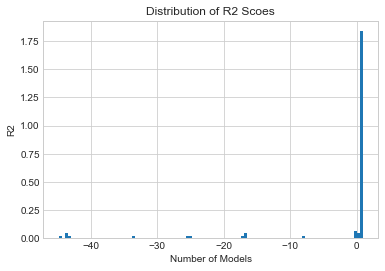

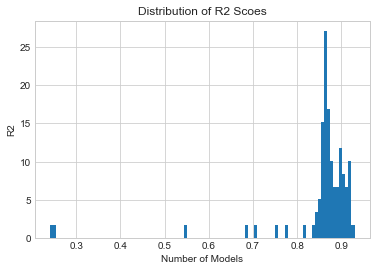

In [11]:
from matplotlib import pyplot as plt
if True:
    # plot deep results as a function of number of features

    n_features_dict = {name:config.n_features for name,config in configs.items()}
    to_plot = pd.DataFrame([[name, scores_deep["R2"][name],n_features_dict[name]] for name in scores_deep["R2"].keys()]
                           ,columns = ["name","score","n_features"])

    fig, ax = plt.subplots()
    ax.hist(to_plot["score"],bins=100,density=True)
    #ax.set_xscale('log')
    #ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
    ax.set_xlabel("Number of Models")
    ax.set_ylabel("R2")
    ax.set_title("Distribution of R2 Scoes")
    plt.savefig(log_dir / f"dist_plot.png",bbox_inches='tight')
    #plt.savefig(log_dir / f"pp_deep_pls_compressed.png",bbox_inches='tight')

    n_features_dict = {name:config.n_features for name,config in configs.items()}
    to_plot = pd.DataFrame([[name, scores_deep["R2"][name],n_features_dict[name]] for name in scores_deep["R2"].keys()]
                           ,columns = ["name","score","n_features"])
    to_plot = to_plot[to_plot["score"]>=0]

    fig, ax = plt.subplots()
    ax.hist(to_plot["score"],bins=100,density=True)
    #ax.set_xscale('log')
    #ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
    ax.set_xlabel("Number of Models")
    ax.set_ylabel("R2")
    ax.set_title("Distribution of R2 Scoes")
    plt.savefig(log_dir / f"dist_plot_compressed.png",bbox_inches='tight')
    #plt.savefig(log_dir / f"pp_deep_pls_compressed.png",bbox_inches='tight')
    pass

    #plot


In [12]:
summary_logger.info("------------------\n Top 5 performance on Test Set")
summary_logger.info(f"Index - Model - Val MSE - Val R2 - Test MSE - Test R2")
for i,key in enumerate(sorted(scores_deep['MSE'],key=scores_deep['MSE'].get)):
    if i <5:
        summary_logger.info(f"{i} - {key} - {scores_deep['MSE'][key]} -{scores_deep['R2'][key]} - {scores_deep['MSE'][key]} - {scores_deep_final['MSE'][key]} - {scores_deep_final['R2'][key]}")

------------------
 Top 5 performance on Test Set'
Index - Model - Val MSE - Val R2 - Test MSE - Test R2'
0 - random_59 - 0.42715798708023967 -0.9296530954646005 - 0.42715798708023967 - 0.42503891224827856 - 0.9275223459487822'
1 - random_21 - 0.47852009789036615 -0.9211944791793387 - 0.47852009789036615 - 0.4653365705181601 - 0.9206507874843831'
2 - random_82 - 0.4828983874404394 -0.9204734365526689 - 0.4828983874404394 - 0.4706984262614591 - 0.9197364836066988'
3 - random_77 - 0.49345653250734556 -0.9187346587571994 - 0.49345653250734556 - 0.46056812928618734 - 0.92146390229344'
4 - random_5 - 0.4966379684436345 -0.9182107210646717 - 0.4966379684436345 - 0.4786894189520725 - 0.9183738591808726'


In [13]:
model_path = Path('D:/workspace/lazydeep/experiments/1.01/')
log_path = Path("D:/workspace/lazydeep/experiments/1.02")

log_dir = log_path / re.sub(r'\.(?=csv$)[^.]+$', '',file_name)
model_dir = model_path / re.sub(r'\.(?=csv$)[^.]+$', '',file_name)

if not log_dir.exists():
    log_dir.mkdir()
    
ut.setup_logger(logger_name="",file_name=log_dir/"log.txt")
ut.setup_logger(logger_name="summary2",file_name=log_dir/"summary.txt")
summary_logger = logging.getLogger("summary2")
tb = SummaryWriter(log_dir/"tb")

    
    
deep_scores_dict={}
deep_preds_dict={}
actual_y = None
preprocessing=PLSRegression(n_components=selected_comps)

load_fun_cv = lambda name,model, fold : model.load_state(model_dir/'models'/name/f"_fold_{fold}")
load_fun_pp_cv = lambda fold : preprocessing.from_state(preprocessing.load_state(model_dir/'preprocessing'/f"_fold_{fold}"))
load_fun_build = lambda name,model : model.load_state(model_dir/'models'/name/f"_final")
load_fun_pp_build = lambda : preprocessing.from_state(preprocessing.load_state(model_dir/'preprocessing'/f"_final"))

deep_scheme = DeepScheme(configs, fixed_hyperparams=fixed_hyperparams,loss_eval=loss_target,device=device,tensorboard=tb,adaptive_lr=False,update=False)
deep_scores, deep_preds, _ , _, _,_ = eval.evaluate(deep_models,dataset,deep_scheme,logger_name="log",load_fun=load_fun_cv,load_fun_pp=load_fun_pp_cv)


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Tested (test) on 1905 instances with mean losses of: random_0:0.8233,random_1:0.807,random_2:0.6161,random_3:264.4626,random_4:0.8111,random_5:0.5017,random_6:271.8982,random_7:0.5023,random_8:0.5081,random_9:0.9613,random_10:0.7669,random_11:0.5153,random_12:0.5384,random_13:0.7874,random_14:6.1302,random_15:0.975,random_16:0.5693,random_17:1.1252,random_18:0.5785,random_19:0.5572,random_20:0.8867,random_21:0.4698,random_22:0.9858,random_23:0.7741,random_24:0.8587,random_25:0.7535,random_26:0.5371,random_27:0.8033,random_28:0.8394,random_29:0.7193,random_30:0.562,random_31:0.9906,random_32:0.6003,random_33:273.8991,random_34:0.7762,random_35:0.7732,random_36:0.8258,random_37:0.9836,random_38:6.1238,random_39:0.6793,random_40:0.7944,random_41:0.5056,random_42:0.5355,random_43:0.7195,random_44:0.8293,random_45:280.2945,random_46:0.9234,

In [14]:
deep_scores_final, deep_preds_final, _ ,_, _,_ = eval.build(deep_models,dataset,deep_scheme,logger_name="test_log",load_fun=load_fun_build,load_fun_pp=load_fun_pp_build)

Building final model - Train 7413 - Test 1448'
Tested (test) on 1448 instances with mean losses of: random_0:0.7685,random_1:0.7583,random_2:0.5721,random_3:0.7352,random_4:0.9395,random_5:0.4787,random_6:268.574,random_7:0.5215,random_8:0.4096,random_9:0.6976,random_10:0.721,random_11:0.5018,random_12:0.6168,random_13:0.8155,random_14:5.8929,random_15:0.7487,random_16:0.8943,random_17:0.6826,random_18:0.5464,random_19:0.7058,random_20:0.7599,random_21:0.4653,random_22:0.7639,random_23:0.7092,random_24:0.6862,random_25:0.7037,random_26:0.4857,random_27:0.8335,random_28:1.1731,random_29:0.6543,random_30:0.6504,random_31:0.7207,random_32:0.5668,random_33:270.5625,random_34:0.7065,random_35:0.6982,random_36:0.6176,random_37:1.026,random_38:0.7917,random_39:0.4505,random_40:0.7275,random_41:0.4609,random_42:0.5744,random_43:0.7258,random_44:0.6989,random_45:276.9312,random_46:0.7984,random_47:0.6308,random_48:0.6628,random_49:0.7918,random_50:0.7511,random_51:0.6939,random_52:0.7636,random

In [15]:
all_scores = []
for k,v in ut.flip_dicts(deep_scores).items():
    dict1 = {'model_num':k,"predictor":"deep"}
    all_scores.append({**dict1,**v})
    
all_scores_final = []
for k,v in ut.flip_dicts(deep_scores_final).items():
    dict1 = {'model_num':k,"predictor":"deep"}
    all_scores_final.append({**dict1,**v})  

scores_df_sorted = pd.DataFrame(all_scores).sort_values(by='MSE')
for i,(index,row) in enumerate(scores_df_sorted.iterrows()):
    s = f"{i} - " + " - ".join([f"{i}" for i in row.tolist()])
    print(s)

0 - random_59 - deep - 0.41344394868440204 - 0.4268353875640713 - 0.38668853449156804 - 0.4572330106437476 - 0.45067953918038345 - 0.42715798708023967 - 0.9296530954646005
1 - random_21 - deep - 0.46982851644826373 - 0.4829046178351888 - 0.4421578718634937 - 0.5073498061939122 - 0.48945786849971135 - 0.47852009789036615 - 0.9211944791793387
2 - random_82 - deep - 0.4732125640228352 - 0.4900174628743125 - 0.4473183443082259 - 0.5129462654654137 - 0.49000114415925466 - 0.4828983874404394 - 0.9204734365526689
3 - random_77 - deep - 0.4860427215969156 - 0.4911194901332221 - 0.43916691134255387 - 0.5363065382234411 - 0.5134993734357267 - 0.49345653250734556 - 0.9187346587571994
4 - random_5 - deep - 0.5017142913316491 - 0.48238601705912126 - 0.45223166167766826 - 0.5203985189180867 - 0.5261903511747895 - 0.4966379684436345 - 0.9182107210646717
5 - random_32 - deep - 0.6002785096018333 - 0.47158061427533476 - 0.41952084913411336 - 0.5031710790293249 - 0.4923633533434727 - 0.49703222356799426

In [16]:
from sk_models import setup_pls_models_exh, StandardScaler, PLSRegression
from plot import plot_preds_and_res

for deep_name,deep_model in deep_models.items():
    logging.getLogger().info(f"Running model {deep_name}")
    temp_dict = {deep_name:deep_model}

    lwr_scheme = DeepLWRScheme_1_to_n(lwr_models = setup_pls_models_exh(nrow),n_neighbours=500,loss_fun_sk = mean_squared_error)
    lwr_scores, lwr_preds, _ , _, _,_= eval.evaluate(temp_dict,dataset,lwr_scheme,logger_name="log",load_fun=load_fun_cv,load_fun_pp = load_fun_pp_cv)
    lwr_scores_final, lwr_preds_final, _ , _, _,_= eval.build(temp_dict,dataset,lwr_scheme,logger_name="test_log",load_fun=load_fun_build,load_fun_pp = load_fun_pp_build)

    #scores
    for k,v in ut.flip_dicts(lwr_scores).items():
        dict1 = {'model_num':deep_name,"predictor":k}
        all_scores.append({**dict1,**v})

    for k,v in ut.flip_dicts(lwr_scores_final).items():
        dict1 = {'model_num':deep_name,"predictor":k}
        all_scores_final.append({**dict1,**v})

    lwr_preds['deep'] = deep_preds[deep_name]
    lwr_preds_final['deep'] = deep_preds_final[deep_name]

    if not (log_dir/deep_name).exists():
        (log_dir/deep_name).mkdir()    
    
    lwr_preds.to_csv(log_dir/deep_name/ f"predictions.csv",index=False)
    lwr_preds_final.to_csv(log_dir/deep_name/ f"predictions_test.csv",index=False)

    #preds
    # todo save predictions - appending solns
    plot_preds_and_res(lwr_preds,name_lambda=lambda x:f"{deep_name} with {x} predictor",save_lambda= lambda x:f"deep_lwr{x}",save_loc=log_dir/deep_name)



Running model random_0'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7533,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0008,lwr_k=50:0.0176,lwr_k=100:0.2657,lwr_k=200:0.419,lwr_k=300:0.4968,lwr_k=400:0.5379,lwr_k=500:0.5705,lwr_k=600:0.5913,lwr_k=700:0.6102,lwr_k=800:0.6219,lwr_k=900:0.6364,lwr_k=1000:0.6466'
Tested (test) on 1905 instances with mean losses of: lr:0.7771,lwr_k=10:1.528,lwr_k=20:10.7291,lwr_k=30:110.3397,lwr_k=40:170.0465,lwr_k=50:1186482.2132,lwr_k=100:317.9196,lwr_k=200:76.0814,lwr_k=300:0.8287,lwr_k=400:0.7153,lwr_k=500:0.6886,lwr_k=600:0.7015,lwr_k=700:0.7012,lwr_k=800:0.7064,lwr_k=900:0.7152,lwr_k=1000:0.7193'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7111,lwr_k=10:0.0,lwr_k=20:0.0

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_1'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.624,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.2483,lwr_k=40:0.2978,lwr_k=50:0.3363,lwr_k=100:0.4375,lwr_k=200:0.5092,lwr_k=300:0.5403,lwr_k=400:0.5602,lwr_k=500:0.5767,lwr_k=600:0.5842,lwr_k=700:0.5843,lwr_k=800:0.5867,lwr_k=900:0.5913,lwr_k=1000:0.594'
Tested (test) on 1905 instances with mean losses of: lr:0.6572,lwr_k=10:12.0072,lwr_k=20:80.9896,lwr_k=30:59311.152,lwr_k=40:2007.4825,lwr_k=50:1177.6288,lwr_k=100:1.3765,lwr_k=200:14.2111,lwr_k=300:0.667,lwr_k=400:0.6646,lwr_k=500:0.6562,lwr_k=600:0.6459,lwr_k=700:0.6427,lwr_k=800:0.6402,lwr_k=900:0.6412,lwr_k=1000:0.642'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6698,lwr_k=10:0.0,lwr_k=20:0.0,

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_2'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.4966,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0951,lwr_k=40:0.1656,lwr_k=50:0.2131,lwr_k=100:0.3194,lwr_k=200:0.3769,lwr_k=300:0.4008,lwr_k=400:0.4163,lwr_k=500:0.4251,lwr_k=600:0.4305,lwr_k=700:0.4366,lwr_k=800:0.4415,lwr_k=900:0.4454,lwr_k=1000:0.4479'
Tested (test) on 1905 instances with mean losses of: lr:0.5395,lwr_k=10:2.929,lwr_k=20:67.2144,lwr_k=30:2.6325,lwr_k=40:1.1255,lwr_k=50:0.9805,lwr_k=100:0.5619,lwr_k=200:0.5188,lwr_k=300:0.5074,lwr_k=400:0.5059,lwr_k=500:0.5077,lwr_k=600:0.5081,lwr_k=700:0.5093,lwr_k=800:0.5129,lwr_k=900:0.515,lwr_k=1000:0.5168'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.4792,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_3'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.1161,lwr_k=10:0.7007,lwr_k=20:1.6295,lwr_k=30:2.0105,lwr_k=40:2.2166,lwr_k=50:2.3411,lwr_k=100:2.7379,lwr_k=200:3.0216,lwr_k=300:3.1799,lwr_k=400:3.3106,lwr_k=500:3.4162,lwr_k=600:3.501,lwr_k=700:3.5783,lwr_k=800:3.6649,lwr_k=900:3.7548,lwr_k=1000:3.8445'
Tested (test) on 1905 instances with mean losses of: lr:5.0678,lwr_k=10:12897789.0923,lwr_k=20:1234831.539,lwr_k=30:36617.0921,lwr_k=40:2132801.9122,lwr_k=50:11982.1411,lwr_k=100:3.5955,lwr_k=200:4.0302,lwr_k=300:4.0654,lwr_k=400:3.7807,lwr_k=500:3.575,lwr_k=600:3.6403,lwr_k=700:3.6885,lwr_k=800:3.7489,lwr_k=900:3.7288,lwr_k=1000:3.8196'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.1593,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_4'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7424,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lwr_k=50:0.001,lwr_k=100:0.2117,lwr_k=200:0.3874,lwr_k=300:0.4615,lwr_k=400:0.5109,lwr_k=500:0.5431,lwr_k=600:0.5669,lwr_k=700:0.5863,lwr_k=800:0.6031,lwr_k=900:0.6182,lwr_k=1000:0.6244'
Tested (test) on 1905 instances with mean losses of: lr:0.7853,lwr_k=10:1.3097,lwr_k=20:2.1521,lwr_k=30:2.9244,lwr_k=40:6.5977,lwr_k=50:50.0557,lwr_k=100:1.6482,lwr_k=200:0.6899,lwr_k=300:0.6396,lwr_k=400:0.6392,lwr_k=500:0.6511,lwr_k=600:0.6565,lwr_k=700:0.6628,lwr_k=800:0.6653,lwr_k=900:0.6714,lwr_k=1000:0.675'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.8365,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_5'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.3893,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0602,lwr_k=40:0.1374,lwr_k=50:1.6434,lwr_k=100:1.3139,lwr_k=200:1.0283,lwr_k=300:1.2155,lwr_k=400:0.7579,lwr_k=500:0.5854,lwr_k=600:0.5245,lwr_k=700:0.4783,lwr_k=800:0.444,lwr_k=900:0.4208,lwr_k=1000:0.4008'
Tested (test) on 1905 instances with mean losses of: lr:0.4769,lwr_k=10:4.4288,lwr_k=20:551.5817,lwr_k=30:824.0668,lwr_k=40:3.8052,lwr_k=50:6.4044,lwr_k=100:2.4441,lwr_k=200:1.6505,lwr_k=300:1.3453,lwr_k=400:0.8512,lwr_k=500:0.7216,lwr_k=600:0.6466,lwr_k=700:0.5887,lwr_k=800:0.5486,lwr_k=900:0.5325,lwr_k=1000:0.4987'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.3929,lwr_k=10:0.0,lwr_k=20:0.0001,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_6'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.0961,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0118,lwr_k=50:0.0621,lwr_k=100:0.5618,lwr_k=200:0.7155,lwr_k=300:0.7936,lwr_k=400:0.897,lwr_k=500:0.9645,lwr_k=600:1.0548,lwr_k=700:1.1333,lwr_k=800:1.2157,lwr_k=900:1.2862,lwr_k=1000:1.3567'
Tested (test) on 1905 instances with mean losses of: lr:3.1859,lwr_k=10:2.3975,lwr_k=20:4.1413,lwr_k=30:36.0521,lwr_k=40:58.6369,lwr_k=50:421.2744,lwr_k=100:85.8739,lwr_k=200:188.9684,lwr_k=300:19.6653,lwr_k=400:1.3392,lwr_k=500:1.3315,lwr_k=600:1.433,lwr_k=700:1.4003,lwr_k=800:1.5031,lwr_k=900:1.571,lwr_k=1000:2.7238'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.4937,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_7'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.4153,lwr_k=10:0.0667,lwr_k=20:0.2325,lwr_k=30:0.2749,lwr_k=40:0.3048,lwr_k=50:0.3196,lwr_k=100:0.3639,lwr_k=200:0.3892,lwr_k=300:0.3952,lwr_k=400:0.4018,lwr_k=500:0.4045,lwr_k=600:0.4068,lwr_k=700:0.4075,lwr_k=800:0.4082,lwr_k=900:0.4094,lwr_k=1000:0.4101'
Tested (test) on 1905 instances with mean losses of: lr:0.4848,lwr_k=10:1084998.8896,lwr_k=20:1864874.5661,lwr_k=30:218866.7573,lwr_k=40:10499.7265,lwr_k=50:1199.9479,lwr_k=100:11.5243,lwr_k=200:0.4891,lwr_k=300:0.4893,lwr_k=400:0.4918,lwr_k=500:0.4856,lwr_k=600:0.4844,lwr_k=700:0.485,lwr_k=800:0.4862,lwr_k=900:0.4859,lwr_k=1000:0.486'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.4311,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_8'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.4243,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0007,lwr_k=50:0.0104,lwr_k=100:0.1608,lwr_k=200:0.2773,lwr_k=300:0.322,lwr_k=400:0.3487,lwr_k=500:0.3625,lwr_k=600:0.3728,lwr_k=700:0.3797,lwr_k=800:0.3851,lwr_k=900:0.3899,lwr_k=1000:0.3942'
Tested (test) on 1905 instances with mean losses of: lr:0.5111,lwr_k=10:1.7864,lwr_k=20:6.1566,lwr_k=30:22.9385,lwr_k=40:484.5569,lwr_k=50:560.6092,lwr_k=100:497.2317,lwr_k=200:0.5886,lwr_k=300:0.5575,lwr_k=400:0.5439,lwr_k=500:0.5276,lwr_k=600:0.5201,lwr_k=700:0.5173,lwr_k=800:0.5169,lwr_k=900:0.5137,lwr_k=1000:0.5142'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.5174,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_9'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7508,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lwr_k=50:0.0072,lwr_k=100:0.2281,lwr_k=200:0.407,lwr_k=300:0.4701,lwr_k=400:0.5108,lwr_k=500:0.5469,lwr_k=600:0.5705,lwr_k=700:0.5886,lwr_k=800:0.6022,lwr_k=900:0.6111,lwr_k=1000:0.6197'
Tested (test) on 1905 instances with mean losses of: lr:0.7736,lwr_k=10:0.931,lwr_k=20:1.1244,lwr_k=30:1.6661,lwr_k=40:3.4477,lwr_k=50:11.9774,lwr_k=100:0.805,lwr_k=200:0.6619,lwr_k=300:0.658,lwr_k=400:0.6745,lwr_k=500:0.6744,lwr_k=600:0.6792,lwr_k=700:0.6834,lwr_k=800:0.6896,lwr_k=900:0.6919,lwr_k=1000:0.6945'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6568,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_10'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6733,lwr_k=10:0.0,lwr_k=20:0.0763,lwr_k=30:0.2441,lwr_k=40:0.3279,lwr_k=50:0.3757,lwr_k=100:0.4982,lwr_k=200:0.568,lwr_k=300:0.5944,lwr_k=400:0.6101,lwr_k=500:0.6202,lwr_k=600:0.6271,lwr_k=700:0.6332,lwr_k=800:0.6378,lwr_k=900:0.641,lwr_k=1000:0.6444'
Tested (test) on 1905 instances with mean losses of: lr:0.6963,lwr_k=10:11.459,lwr_k=20:12.8804,lwr_k=30:9.8781,lwr_k=40:2.7941,lwr_k=50:1.6306,lwr_k=100:0.8595,lwr_k=200:0.658,lwr_k=300:0.6692,lwr_k=400:0.6773,lwr_k=500:0.6834,lwr_k=600:0.6827,lwr_k=700:0.6796,lwr_k=800:0.6816,lwr_k=900:0.6867,lwr_k=1000:0.69'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7096,lwr_k=10:0.0,lwr_k=20:0.0705,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_11'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.4221,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0165,lwr_k=50:0.058,lwr_k=100:0.3162,lwr_k=200:0.3098,lwr_k=300:0.3243,lwr_k=400:0.3403,lwr_k=500:0.3579,lwr_k=600:0.3634,lwr_k=700:0.3717,lwr_k=800:0.3777,lwr_k=900:0.382,lwr_k=1000:0.3854'
Tested (test) on 1905 instances with mean losses of: lr:0.4902,lwr_k=10:1.5295,lwr_k=20:6.2281,lwr_k=30:6.7573,lwr_k=40:14.4488,lwr_k=50:8.0056,lwr_k=100:1.2222,lwr_k=200:0.5942,lwr_k=300:0.5484,lwr_k=400:0.4845,lwr_k=500:0.4735,lwr_k=600:0.483,lwr_k=700:0.4783,lwr_k=800:0.4798,lwr_k=900:0.4792,lwr_k=1000:0.4766'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.4318,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_12'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.5001,lwr_k=10:0.3606,lwr_k=20:0.4209,lwr_k=30:0.4399,lwr_k=40:0.4487,lwr_k=50:0.4555,lwr_k=100:0.4734,lwr_k=200:0.4801,lwr_k=300:0.4852,lwr_k=400:0.4877,lwr_k=500:0.4897,lwr_k=600:0.4918,lwr_k=700:0.4926,lwr_k=800:0.4935,lwr_k=900:0.4937,lwr_k=1000:0.4943'
Tested (test) on 1905 instances with mean losses of: lr:0.5359,lwr_k=10:0.8417,lwr_k=20:0.7133,lwr_k=30:0.6491,lwr_k=40:0.5506,lwr_k=50:0.5437,lwr_k=100:0.5398,lwr_k=200:0.5359,lwr_k=300:0.5351,lwr_k=400:0.5361,lwr_k=500:0.5335,lwr_k=600:0.5332,lwr_k=700:0.5314,lwr_k=800:0.5311,lwr_k=900:0.5305,lwr_k=1000:0.5298'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.5968,lwr_k=10:0.3632,lwr_k=20:0.

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_13'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7137,lwr_k=10:0.0,lwr_k=20:0.3071,lwr_k=30:0.42,lwr_k=40:0.4819,lwr_k=50:0.5214,lwr_k=100:0.5861,lwr_k=200:0.6279,lwr_k=300:0.6439,lwr_k=400:0.6552,lwr_k=500:0.6621,lwr_k=600:0.6664,lwr_k=700:0.6701,lwr_k=800:0.6731,lwr_k=900:0.676,lwr_k=1000:0.6786'
Tested (test) on 1905 instances with mean losses of: lr:0.7208,lwr_k=10:878.6602,lwr_k=20:1.1433,lwr_k=30:0.7962,lwr_k=40:0.731,lwr_k=50:0.6981,lwr_k=100:0.6624,lwr_k=200:0.6694,lwr_k=300:0.6717,lwr_k=400:0.6747,lwr_k=500:0.6828,lwr_k=600:0.6854,lwr_k=700:0.6894,lwr_k=800:0.6907,lwr_k=900:0.6941,lwr_k=1000:0.696'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7125,lwr_k=10:0.0,lwr_k=20:0.2956,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_14'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:6.1441,lwr_k=10:6.6693,lwr_k=20:6.177,lwr_k=30:6.1445,lwr_k=40:6.1446,lwr_k=50:6.149,lwr_k=100:6.1447,lwr_k=200:6.1498,lwr_k=300:6.1503,lwr_k=400:6.1668,lwr_k=500:6.1791,lwr_k=600:6.1654,lwr_k=700:6.16,lwr_k=800:6.1675,lwr_k=900:6.1636,lwr_k=1000:6.1654'
Tested (test) on 1905 instances with mean losses of: lr:6.1322,lwr_k=10:6.5221,lwr_k=20:6.199,lwr_k=30:6.1362,lwr_k=40:6.1285,lwr_k=50:6.1241,lwr_k=100:6.1282,lwr_k=200:6.1521,lwr_k=300:6.153,lwr_k=400:6.1831,lwr_k=500:6.2021,lwr_k=600:6.1807,lwr_k=700:6.1716,lwr_k=800:6.1842,lwr_k=900:6.1778,lwr_k=1000:6.1807'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:6.1302,lwr_k=10:6.1303,lwr_k=20:6.4277,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_15'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.8025,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.091,lwr_k=50:0.169,lwr_k=100:0.3497,lwr_k=200:0.4761,lwr_k=300:0.5308,lwr_k=400:0.5721,lwr_k=500:0.5976,lwr_k=600:0.6209,lwr_k=700:0.6379,lwr_k=800:0.649,lwr_k=900:0.6579,lwr_k=1000:0.667'
Tested (test) on 1905 instances with mean losses of: lr:0.8098,lwr_k=10:1.4445,lwr_k=20:2.4072,lwr_k=30:853.8769,lwr_k=40:1.7342,lwr_k=50:1.0738,lwr_k=100:0.6353,lwr_k=200:0.6164,lwr_k=300:0.6397,lwr_k=400:0.6594,lwr_k=500:0.6751,lwr_k=600:0.6803,lwr_k=700:0.685,lwr_k=800:0.6933,lwr_k=900:0.699,lwr_k=1000:0.7023'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7363,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_16'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.4543,lwr_k=10:0.3968,lwr_k=20:0.423,lwr_k=30:0.4305,lwr_k=40:0.4346,lwr_k=50:0.4369,lwr_k=100:0.44,lwr_k=200:0.4425,lwr_k=300:0.4444,lwr_k=400:0.4451,lwr_k=500:0.446,lwr_k=600:0.4462,lwr_k=700:0.447,lwr_k=800:0.4478,lwr_k=900:0.4485,lwr_k=1000:0.4492'
Tested (test) on 1905 instances with mean losses of: lr:0.5535,lwr_k=10:0.5804,lwr_k=20:0.559,lwr_k=30:0.553,lwr_k=40:0.5514,lwr_k=50:0.5498,lwr_k=100:0.542,lwr_k=200:0.5428,lwr_k=300:0.5438,lwr_k=400:0.5441,lwr_k=500:0.5454,lwr_k=600:0.5461,lwr_k=700:0.5472,lwr_k=800:0.5478,lwr_k=900:0.5481,lwr_k=1000:0.5487'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.4889,lwr_k=10:0.4134,lwr_k=20:0.448,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_17'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6085,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0015,lwr_k=40:0.069,lwr_k=50:0.1335,lwr_k=100:0.3362,lwr_k=200:0.4457,lwr_k=300:0.4939,lwr_k=400:0.5195,lwr_k=500:0.534,lwr_k=600:0.5458,lwr_k=700:0.5519,lwr_k=800:0.5601,lwr_k=900:0.5648,lwr_k=1000:0.569'
Tested (test) on 1905 instances with mean losses of: lr:0.6553,lwr_k=10:2.5492,lwr_k=20:5.6361,lwr_k=30:93.1631,lwr_k=40:35.0771,lwr_k=50:21.6028,lwr_k=100:1.2526,lwr_k=200:0.6495,lwr_k=300:0.6337,lwr_k=400:0.6344,lwr_k=500:0.6262,lwr_k=600:0.6235,lwr_k=700:0.6223,lwr_k=800:0.6216,lwr_k=900:0.6213,lwr_k=1000:0.6213'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.5824,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=3

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_18'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.5423,lwr_k=10:0.0,lwr_k=20:0.0047,lwr_k=30:0.375,lwr_k=40:2.4657,lwr_k=50:1.8837,lwr_k=100:1.4378,lwr_k=200:1.1543,lwr_k=300:1.0129,lwr_k=400:0.8914,lwr_k=500:0.811,lwr_k=600:0.7585,lwr_k=700:0.6697,lwr_k=800:0.6322,lwr_k=900:0.6055,lwr_k=1000:0.5934'
Tested (test) on 1905 instances with mean losses of: lr:0.5624,lwr_k=10:10.2543,lwr_k=20:1588.1583,lwr_k=30:2307.0256,lwr_k=40:152.6709,lwr_k=50:199.8958,lwr_k=100:2.4751,lwr_k=200:1.7998,lwr_k=300:1.093,lwr_k=400:1.0885,lwr_k=500:0.9426,lwr_k=600:0.8,lwr_k=700:0.7105,lwr_k=800:0.6866,lwr_k=900:0.6681,lwr_k=1000:0.6431'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.5613,lwr_k=10:0.0,lwr_k=20:0.0

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_19'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.4559,lwr_k=10:0.3933,lwr_k=20:0.4226,lwr_k=30:0.4288,lwr_k=40:0.4365,lwr_k=50:0.4406,lwr_k=100:0.4451,lwr_k=200:0.4495,lwr_k=300:0.4512,lwr_k=400:0.4514,lwr_k=500:0.4522,lwr_k=600:0.4525,lwr_k=700:0.4529,lwr_k=800:0.453,lwr_k=900:0.453,lwr_k=1000:0.453'
Tested (test) on 1905 instances with mean losses of: lr:0.531,lwr_k=10:0.6166,lwr_k=20:0.574,lwr_k=30:0.551,lwr_k=40:0.5465,lwr_k=50:0.5415,lwr_k=100:0.5356,lwr_k=200:0.5325,lwr_k=300:0.5315,lwr_k=400:0.53,lwr_k=500:0.5294,lwr_k=600:0.5294,lwr_k=700:0.5301,lwr_k=800:0.5305,lwr_k=900:0.5306,lwr_k=1000:0.5299'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.5988,lwr_k=10:0.5751,lwr_k=20:0.5512,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_20'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.8426,lwr_k=10:0.2013,lwr_k=20:0.4512,lwr_k=30:0.542,lwr_k=40:0.5863,lwr_k=50:0.6165,lwr_k=100:0.6815,lwr_k=200:0.7245,lwr_k=300:0.7401,lwr_k=400:0.7525,lwr_k=500:0.7624,lwr_k=600:0.7681,lwr_k=700:0.7732,lwr_k=800:0.777,lwr_k=900:0.7798,lwr_k=1000:0.7821'
Tested (test) on 1905 instances with mean losses of: lr:0.8538,lwr_k=10:2.5713,lwr_k=20:0.8355,lwr_k=30:0.7613,lwr_k=40:0.7564,lwr_k=50:0.7431,lwr_k=100:0.7471,lwr_k=200:0.7503,lwr_k=300:0.7617,lwr_k=400:0.7649,lwr_k=500:0.7677,lwr_k=600:0.7715,lwr_k=700:0.7735,lwr_k=800:0.7746,lwr_k=900:0.7742,lwr_k=1000:0.7759'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.8618,lwr_k=10:0.2258,lwr_k=20:0.48

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_21'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.3103,lwr_k=10:0.2698,lwr_k=20:0.286,lwr_k=30:0.2917,lwr_k=40:0.2951,lwr_k=50:0.298,lwr_k=100:0.3037,lwr_k=200:0.3071,lwr_k=300:0.3075,lwr_k=400:0.3085,lwr_k=500:0.3087,lwr_k=600:0.3089,lwr_k=700:0.3092,lwr_k=800:0.3092,lwr_k=900:0.3094,lwr_k=1000:0.3093'
Tested (test) on 1905 instances with mean losses of: lr:0.4661,lwr_k=10:0.498,lwr_k=20:0.4822,lwr_k=30:0.4846,lwr_k=40:0.4793,lwr_k=50:0.4734,lwr_k=100:0.4658,lwr_k=200:0.4657,lwr_k=300:0.4655,lwr_k=400:0.4655,lwr_k=500:0.4651,lwr_k=600:0.4649,lwr_k=700:0.4658,lwr_k=800:0.4659,lwr_k=900:0.4661,lwr_k=1000:0.4656'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.2958,lwr_k=10:0.2554,lwr_k=20:0.278

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_22'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7562,lwr_k=10:0.4646,lwr_k=20:0.4566,lwr_k=30:0.5306,lwr_k=40:0.5647,lwr_k=50:0.589,lwr_k=100:0.6442,lwr_k=200:0.675,lwr_k=300:0.6855,lwr_k=400:0.6922,lwr_k=500:0.6953,lwr_k=600:0.6976,lwr_k=700:0.7017,lwr_k=800:0.7029,lwr_k=900:0.7059,lwr_k=1000:0.7082'
Tested (test) on 1905 instances with mean losses of: lr:0.7526,lwr_k=10:250824872.7954,lwr_k=20:39729514.4675,lwr_k=30:4764645.6147,lwr_k=40:254042.2249,lwr_k=50:65253.2481,lwr_k=100:366.5917,lwr_k=200:0.695,lwr_k=300:0.6957,lwr_k=400:0.6964,lwr_k=500:0.6934,lwr_k=600:0.6988,lwr_k=700:0.7027,lwr_k=800:0.7045,lwr_k=900:0.7072,lwr_k=1000:0.7096'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.715

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_23'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6053,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.1134,lwr_k=40:0.2179,lwr_k=50:0.2796,lwr_k=100:0.4201,lwr_k=200:0.4961,lwr_k=300:0.5268,lwr_k=400:0.5428,lwr_k=500:0.55,lwr_k=600:0.554,lwr_k=700:0.5591,lwr_k=800:0.5617,lwr_k=900:0.5645,lwr_k=1000:0.5664'
Tested (test) on 1905 instances with mean losses of: lr:0.6598,lwr_k=10:3.0867,lwr_k=20:260.6378,lwr_k=30:1.9858,lwr_k=40:0.9217,lwr_k=50:0.7728,lwr_k=100:0.6449,lwr_k=200:0.624,lwr_k=300:0.6212,lwr_k=400:0.6251,lwr_k=500:0.6299,lwr_k=600:0.6303,lwr_k=700:0.6281,lwr_k=800:0.6276,lwr_k=900:0.6279,lwr_k=1000:0.6311'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6257,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_24'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7352,lwr_k=10:0.4874,lwr_k=20:0.555,lwr_k=30:0.5772,lwr_k=40:0.591,lwr_k=50:0.5993,lwr_k=100:0.6166,lwr_k=200:0.6217,lwr_k=300:0.6283,lwr_k=400:0.6301,lwr_k=500:0.6308,lwr_k=600:0.6313,lwr_k=700:0.632,lwr_k=800:0.6322,lwr_k=900:0.6325,lwr_k=1000:0.6346'
Tested (test) on 1905 instances with mean losses of: lr:0.7896,lwr_k=10:0.8709,lwr_k=20:0.7641,lwr_k=30:0.7277,lwr_k=40:0.7102,lwr_k=50:0.7051,lwr_k=100:0.6945,lwr_k=200:0.687,lwr_k=300:0.684,lwr_k=400:0.6835,lwr_k=500:0.6819,lwr_k=600:0.6827,lwr_k=700:0.6838,lwr_k=800:0.6843,lwr_k=900:0.685,lwr_k=1000:0.6849'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6106,lwr_k=10:0.4758,lwr_k=20:0.548,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_25'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7086,lwr_k=10:0.0,lwr_k=20:0.2082,lwr_k=30:0.3428,lwr_k=40:0.4178,lwr_k=50:0.47,lwr_k=100:0.5764,lwr_k=200:0.6375,lwr_k=300:0.6555,lwr_k=400:0.6644,lwr_k=500:0.6713,lwr_k=600:0.6748,lwr_k=700:0.6823,lwr_k=800:0.685,lwr_k=900:0.687,lwr_k=1000:0.6889'
Tested (test) on 1905 instances with mean losses of: lr:0.736,lwr_k=10:7.0983,lwr_k=20:1.9241,lwr_k=30:0.9977,lwr_k=40:0.8594,lwr_k=50:0.8022,lwr_k=100:0.7225,lwr_k=200:0.7107,lwr_k=300:0.7141,lwr_k=400:0.7094,lwr_k=500:0.7132,lwr_k=600:0.7168,lwr_k=700:0.7167,lwr_k=800:0.7192,lwr_k=900:0.7212,lwr_k=1000:0.7217'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.8472,lwr_k=10:0.0,lwr_k=20:0.1872,lwr_k=

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_26'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.4032,lwr_k=10:0.2969,lwr_k=20:0.3365,lwr_k=30:0.3502,lwr_k=40:0.3548,lwr_k=50:0.3614,lwr_k=100:0.3708,lwr_k=200:0.3784,lwr_k=300:0.3803,lwr_k=400:0.3828,lwr_k=500:0.3854,lwr_k=600:0.3869,lwr_k=700:0.388,lwr_k=800:0.3893,lwr_k=900:0.3915,lwr_k=1000:0.3915'
Tested (test) on 1905 instances with mean losses of: lr:0.5165,lwr_k=10:0.7053,lwr_k=20:0.6171,lwr_k=30:0.5282,lwr_k=40:1295426274.1192,lwr_k=50:1349649731.2274,lwr_k=100:6431534.8752,lwr_k=200:1043215.9342,lwr_k=300:42844.1358,lwr_k=400:19546.3329,lwr_k=500:4342.3396,lwr_k=600:1394.9307,lwr_k=700:4544.2145,lwr_k=800:6732.2646,lwr_k=900:3.4591,lwr_k=1000:3203.8536'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_27'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.615,lwr_k=10:0.0,lwr_k=20:0.1712,lwr_k=30:0.2985,lwr_k=40:0.3612,lwr_k=50:0.4049,lwr_k=100:0.4881,lwr_k=200:0.538,lwr_k=300:0.56,lwr_k=400:0.5733,lwr_k=500:0.5783,lwr_k=600:0.5828,lwr_k=700:0.5844,lwr_k=800:0.5876,lwr_k=900:0.5893,lwr_k=1000:0.5913'
Tested (test) on 1905 instances with mean losses of: lr:0.6673,lwr_k=10:10.2085,lwr_k=20:8321017.5545,lwr_k=30:5967.966,lwr_k=40:3982.9912,lwr_k=50:2039.9941,lwr_k=100:29.4102,lwr_k=200:0.6893,lwr_k=300:0.6652,lwr_k=400:0.658,lwr_k=500:0.6549,lwr_k=600:0.6539,lwr_k=700:0.6488,lwr_k=800:0.6491,lwr_k=900:0.6484,lwr_k=1000:0.649'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6189,lwr_k=10:0.0,lwr_k=2

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_28'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7986,lwr_k=10:0.6286,lwr_k=20:0.7007,lwr_k=30:0.7297,lwr_k=40:0.739,lwr_k=50:0.7422,lwr_k=100:0.751,lwr_k=200:0.763,lwr_k=300:0.7638,lwr_k=400:0.7668,lwr_k=500:0.768,lwr_k=600:0.7689,lwr_k=700:0.7706,lwr_k=800:0.7717,lwr_k=900:0.7729,lwr_k=1000:0.7738'
Tested (test) on 1905 instances with mean losses of: lr:0.8155,lwr_k=10:0.8637,lwr_k=20:0.8046,lwr_k=30:0.791,lwr_k=40:0.7817,lwr_k=50:0.7797,lwr_k=100:0.7867,lwr_k=200:0.7933,lwr_k=300:0.7919,lwr_k=400:0.7894,lwr_k=500:0.7897,lwr_k=600:0.7867,lwr_k=700:0.7859,lwr_k=800:0.7865,lwr_k=900:0.7874,lwr_k=1000:0.7881'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7644,lwr_k=10:0.5955,lwr_k=20:0.662,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_29'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6753,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0579,lwr_k=40:0.1286,lwr_k=50:0.1864,lwr_k=100:0.3229,lwr_k=200:0.4611,lwr_k=300:0.5331,lwr_k=400:0.5703,lwr_k=500:0.5899,lwr_k=600:0.6054,lwr_k=700:0.6144,lwr_k=800:0.6181,lwr_k=900:0.6239,lwr_k=1000:0.629'
Tested (test) on 1905 instances with mean losses of: lr:0.7205,lwr_k=10:1.3228,lwr_k=20:4.7066,lwr_k=30:6.0729,lwr_k=40:173.7481,lwr_k=50:1.363,lwr_k=100:373.8074,lwr_k=200:0.7144,lwr_k=300:0.6782,lwr_k=400:0.6673,lwr_k=500:0.6775,lwr_k=600:0.6886,lwr_k=700:0.6885,lwr_k=800:0.6958,lwr_k=900:0.6957,lwr_k=1000:0.699'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7148,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_30'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.4808,lwr_k=10:0.3067,lwr_k=20:0.391,lwr_k=30:0.4166,lwr_k=40:0.4304,lwr_k=50:0.4385,lwr_k=100:0.4542,lwr_k=200:0.4669,lwr_k=300:0.4697,lwr_k=400:0.4711,lwr_k=500:0.4729,lwr_k=600:0.4736,lwr_k=700:0.4747,lwr_k=800:0.4753,lwr_k=900:0.4761,lwr_k=1000:0.4763'
Tested (test) on 1905 instances with mean losses of: lr:0.5366,lwr_k=10:0.8955,lwr_k=20:0.7206,lwr_k=30:0.6335,lwr_k=40:0.5965,lwr_k=50:0.5861,lwr_k=100:0.5562,lwr_k=200:0.5412,lwr_k=300:0.5381,lwr_k=400:0.5365,lwr_k=500:0.5371,lwr_k=600:0.5363,lwr_k=700:0.5341,lwr_k=800:0.5336,lwr_k=900:0.533,lwr_k=1000:0.5337'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.4844,lwr_k=10:0.2793,lwr_k=20:0.37

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_31'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7811,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0191,lwr_k=40:0.0989,lwr_k=50:0.1408,lwr_k=100:0.3527,lwr_k=200:0.5213,lwr_k=300:0.5888,lwr_k=400:0.6269,lwr_k=500:0.6561,lwr_k=600:0.6733,lwr_k=700:0.685,lwr_k=800:0.6939,lwr_k=900:0.7021,lwr_k=1000:0.7104'
Tested (test) on 1905 instances with mean losses of: lr:0.7944,lwr_k=10:1.8003,lwr_k=20:4.0466,lwr_k=30:1313.4054,lwr_k=40:613.1839,lwr_k=50:223.4888,lwr_k=100:765472.5892,lwr_k=200:0.7864,lwr_k=300:0.869,lwr_k=400:0.7336,lwr_k=500:0.7352,lwr_k=600:0.7442,lwr_k=700:0.7492,lwr_k=800:0.75,lwr_k=900:0.7493,lwr_k=1000:0.7525'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7058,lwr_k=10:0.0007,lwr_k=20:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_32'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.5191,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0031,lwr_k=40:0.0839,lwr_k=50:0.1499,lwr_k=100:0.289,lwr_k=200:0.3694,lwr_k=300:0.3993,lwr_k=400:0.4183,lwr_k=500:0.4299,lwr_k=600:0.4372,lwr_k=700:0.4438,lwr_k=800:0.4504,lwr_k=900:0.4553,lwr_k=1000:0.4596'
Tested (test) on 1905 instances with mean losses of: lr:0.5618,lwr_k=10:2.1543,lwr_k=20:6.8796,lwr_k=30:2407.2252,lwr_k=40:21.0488,lwr_k=50:2.3471,lwr_k=100:0.7342,lwr_k=200:0.5618,lwr_k=300:0.5416,lwr_k=400:0.5408,lwr_k=500:0.5384,lwr_k=600:0.5376,lwr_k=700:0.5354,lwr_k=800:0.5357,lwr_k=900:0.5356,lwr_k=1000:0.5341'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.3606,lwr_k=10:0.0,lwr_k=20:0.0,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_33'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:2.9837,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lwr_k=50:0.0017,lwr_k=100:0.2524,lwr_k=200:0.5379,lwr_k=300:0.7008,lwr_k=400:0.8195,lwr_k=500:0.93,lwr_k=600:1.0145,lwr_k=700:1.0888,lwr_k=800:1.1602,lwr_k=900:1.2238,lwr_k=1000:1.2811'
Tested (test) on 1905 instances with mean losses of: lr:3.0979,lwr_k=10:2.9703,lwr_k=20:3.505,lwr_k=30:5.8922,lwr_k=40:16.9689,lwr_k=50:23.9407,lwr_k=100:1.6301,lwr_k=200:1.1074,lwr_k=300:1.084,lwr_k=400:1.2052,lwr_k=500:1.2709,lwr_k=600:1.3666,lwr_k=700:1.4384,lwr_k=800:1.4661,lwr_k=900:1.5462,lwr_k=1000:1.6059'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:2.9728,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_34'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6807,lwr_k=10:0.0,lwr_k=20:0.0002,lwr_k=30:0.053,lwr_k=40:0.151,lwr_k=50:0.7443,lwr_k=100:0.6668,lwr_k=200:0.5678,lwr_k=300:0.5918,lwr_k=400:0.6002,lwr_k=500:0.616,lwr_k=600:0.6127,lwr_k=700:0.6257,lwr_k=800:0.6306,lwr_k=900:0.6368,lwr_k=1000:0.6428'
Tested (test) on 1905 instances with mean losses of: lr:0.6993,lwr_k=10:5.4071,lwr_k=20:75.8956,lwr_k=30:33447.3295,lwr_k=40:132602.5155,lwr_k=50:4375.4706,lwr_k=100:8.467,lwr_k=200:1.4923,lwr_k=300:0.8968,lwr_k=400:0.7855,lwr_k=500:0.722,lwr_k=600:0.6929,lwr_k=700:0.6949,lwr_k=800:0.6933,lwr_k=900:0.6867,lwr_k=1000:0.6876'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7118,lwr_k=10:0.0,lwr_k=20:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_35'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6522,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0028,lwr_k=40:0.0356,lwr_k=50:0.0953,lwr_k=100:0.2148,lwr_k=200:0.3817,lwr_k=300:0.4828,lwr_k=400:0.5408,lwr_k=500:0.5611,lwr_k=600:0.576,lwr_k=700:0.5866,lwr_k=800:0.5911,lwr_k=900:0.5976,lwr_k=1000:0.6011'
Tested (test) on 1905 instances with mean losses of: lr:0.7027,lwr_k=10:1.425,lwr_k=20:2.625,lwr_k=30:102.6071,lwr_k=40:41.3112,lwr_k=50:13.1963,lwr_k=100:1.2656,lwr_k=200:0.8634,lwr_k=300:0.7401,lwr_k=400:0.6981,lwr_k=500:0.683,lwr_k=600:0.6827,lwr_k=700:0.6825,lwr_k=800:0.6815,lwr_k=900:0.6798,lwr_k=1000:0.6831'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6247,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=3

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_36'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7797,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0037,lwr_k=50:0.0747,lwr_k=100:0.2864,lwr_k=200:0.4573,lwr_k=300:0.5227,lwr_k=400:0.5593,lwr_k=500:0.5847,lwr_k=600:0.6085,lwr_k=700:0.627,lwr_k=800:0.6405,lwr_k=900:0.651,lwr_k=1000:0.6612'
Tested (test) on 1905 instances with mean losses of: lr:0.8044,lwr_k=10:1.5032,lwr_k=20:3.1061,lwr_k=30:54.6899,lwr_k=40:3649.6187,lwr_k=50:420952.8879,lwr_k=100:22.7757,lwr_k=200:4.1466,lwr_k=300:0.7551,lwr_k=400:0.7259,lwr_k=500:0.8084,lwr_k=600:0.9092,lwr_k=700:0.89,lwr_k=800:0.7715,lwr_k=900:0.692,lwr_k=1000:0.6987'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6716,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_37'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6018,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0054,lwr_k=40:0.0246,lwr_k=50:0.2992,lwr_k=100:0.3433,lwr_k=200:0.418,lwr_k=300:0.469,lwr_k=400:0.5014,lwr_k=500:0.5173,lwr_k=600:0.5322,lwr_k=700:0.5401,lwr_k=800:0.549,lwr_k=900:0.5538,lwr_k=1000:0.5574'
Tested (test) on 1905 instances with mean losses of: lr:0.651,lwr_k=10:2.4588,lwr_k=20:43.3538,lwr_k=30:1025.9186,lwr_k=40:58353.1938,lwr_k=50:21907.5028,lwr_k=100:13.0637,lwr_k=200:136.1685,lwr_k=300:25.1938,lwr_k=400:1.1798,lwr_k=500:0.6304,lwr_k=600:0.6181,lwr_k=700:0.6191,lwr_k=800:0.6189,lwr_k=900:0.6223,lwr_k=1000:0.6199'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.661,lwr_k=10:0.0,lwr_k=20:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_38'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:270.7489,lwr_k=10:6.6693,lwr_k=20:6.177,lwr_k=30:6.1445,lwr_k=40:6.1446,lwr_k=50:6.149,lwr_k=100:6.1447,lwr_k=200:6.1498,lwr_k=300:6.1503,lwr_k=400:6.1668,lwr_k=500:270.7489,lwr_k=600:6.1654,lwr_k=700:270.7489,lwr_k=800:16644230.1202,lwr_k=900:270.7489,lwr_k=1000:270.7489'
Tested (test) on 1905 instances with mean losses of: lr:273.7752,lwr_k=10:6.5221,lwr_k=20:6.199,lwr_k=30:6.1362,lwr_k=40:6.1285,lwr_k=50:6.1241,lwr_k=100:6.1282,lwr_k=200:6.1521,lwr_k=300:6.153,lwr_k=400:6.1831,lwr_k=500:273.7752,lwr_k=600:6.1807,lwr_k=700:273.7752,lwr_k=800:16643468.1337,lwr_k=900:273.7752,lwr_k=1000:273.7752'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:6.13

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_39'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6011,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0016,lwr_k=50:0.1453,lwr_k=100:0.2804,lwr_k=200:0.4131,lwr_k=300:0.4631,lwr_k=400:0.4889,lwr_k=500:0.5005,lwr_k=600:0.5139,lwr_k=700:0.5206,lwr_k=800:0.5338,lwr_k=900:0.5505,lwr_k=1000:0.5397'
Tested (test) on 1905 instances with mean losses of: lr:0.6217,lwr_k=10:3.0629,lwr_k=20:8.4625,lwr_k=30:19.2769,lwr_k=40:67.1483,lwr_k=50:89.968,lwr_k=100:1.6269,lwr_k=200:0.7756,lwr_k=300:0.6525,lwr_k=400:0.6404,lwr_k=500:0.6222,lwr_k=600:0.6198,lwr_k=700:0.61,lwr_k=800:0.6242,lwr_k=900:0.6629,lwr_k=1000:0.6037'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.4783,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_40'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6317,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.043,lwr_k=40:0.169,lwr_k=50:0.2478,lwr_k=100:0.4156,lwr_k=200:0.5093,lwr_k=300:0.5382,lwr_k=400:0.5597,lwr_k=500:0.5731,lwr_k=600:0.5803,lwr_k=700:0.5861,lwr_k=800:0.5923,lwr_k=900:0.5966,lwr_k=1000:0.5991'
Tested (test) on 1905 instances with mean losses of: lr:0.6723,lwr_k=10:4.1144,lwr_k=20:12.4737,lwr_k=30:33.6207,lwr_k=40:3.0818,lwr_k=50:1.6326,lwr_k=100:0.809,lwr_k=200:0.6816,lwr_k=300:0.6617,lwr_k=400:0.6568,lwr_k=500:0.6542,lwr_k=600:0.6554,lwr_k=700:0.6583,lwr_k=800:0.6622,lwr_k=900:0.6606,lwr_k=1000:0.6593'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6709,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_41'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.4384,lwr_k=10:0.0,lwr_k=20:0.0728,lwr_k=30:0.1791,lwr_k=40:0.2355,lwr_k=50:0.2659,lwr_k=100:0.3404,lwr_k=200:0.3822,lwr_k=300:0.3988,lwr_k=400:0.407,lwr_k=500:0.4113,lwr_k=600:0.4155,lwr_k=700:0.4177,lwr_k=800:0.4204,lwr_k=900:0.4221,lwr_k=1000:0.4244'
Tested (test) on 1905 instances with mean losses of: lr:0.5076,lwr_k=10:42.2112,lwr_k=20:2150.5713,lwr_k=30:632.9018,lwr_k=40:629.222,lwr_k=50:542.4694,lwr_k=100:29.1182,lwr_k=200:6.0562,lwr_k=300:5.4974,lwr_k=400:8.1152,lwr_k=500:2.8287,lwr_k=600:0.9028,lwr_k=700:0.6627,lwr_k=800:0.6355,lwr_k=900:0.6131,lwr_k=1000:0.5761'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.3656,lwr_k=10:0.0,lwr_k=20

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_42'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.3816,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0542,lwr_k=40:0.9277,lwr_k=50:0.7862,lwr_k=100:0.6422,lwr_k=200:0.5027,lwr_k=300:0.4781,lwr_k=400:0.4469,lwr_k=500:0.4418,lwr_k=600:0.4295,lwr_k=700:0.4092,lwr_k=800:0.411,lwr_k=900:0.406,lwr_k=1000:0.3954'
Tested (test) on 1905 instances with mean losses of: lr:0.4923,lwr_k=10:3.8714,lwr_k=20:78.7142,lwr_k=30:27.0172,lwr_k=40:10.5769,lwr_k=50:3.495,lwr_k=100:1.6935,lwr_k=200:0.7289,lwr_k=300:0.693,lwr_k=400:0.6449,lwr_k=500:0.5866,lwr_k=600:0.5793,lwr_k=700:0.5577,lwr_k=800:0.5433,lwr_k=900:0.5486,lwr_k=1000:0.5309'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.4024,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_43'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.635,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0065,lwr_k=40:0.662,lwr_k=50:0.6659,lwr_k=100:0.1033,lwr_k=200:0.1767,lwr_k=300:0.2971,lwr_k=400:0.382,lwr_k=500:0.4366,lwr_k=600:0.4829,lwr_k=700:0.5108,lwr_k=800:0.532,lwr_k=900:0.5465,lwr_k=1000:0.5563'
Tested (test) on 1905 instances with mean losses of: lr:0.6861,lwr_k=10:2.0485,lwr_k=20:4.6897,lwr_k=30:32.7645,lwr_k=40:68525.4928,lwr_k=50:10643446.6074,lwr_k=100:7.3301,lwr_k=200:26.4266,lwr_k=300:1.2369,lwr_k=400:1.1522,lwr_k=500:0.8324,lwr_k=600:0.7946,lwr_k=700:0.7619,lwr_k=800:0.7192,lwr_k=900:0.7022,lwr_k=1000:0.6917'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6528,lwr_k=10:0.0,lwr_k=20:0.

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_44'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7477,lwr_k=10:0.1692,lwr_k=20:0.4145,lwr_k=30:0.5109,lwr_k=40:0.565,lwr_k=50:0.5952,lwr_k=100:0.6665,lwr_k=200:0.6982,lwr_k=300:0.7113,lwr_k=400:0.7178,lwr_k=500:0.7226,lwr_k=600:0.7282,lwr_k=700:0.7319,lwr_k=800:0.7339,lwr_k=900:0.7362,lwr_k=1000:0.7372'
Tested (test) on 1905 instances with mean losses of: lr:0.7764,lwr_k=10:1759.4104,lwr_k=20:5944.4691,lwr_k=30:5.9609,lwr_k=40:1.3737,lwr_k=50:51.2009,lwr_k=100:21.9654,lwr_k=200:0.7989,lwr_k=300:0.7839,lwr_k=400:0.7853,lwr_k=500:0.7784,lwr_k=600:0.7728,lwr_k=700:0.7723,lwr_k=800:0.7748,lwr_k=900:0.7729,lwr_k=1000:0.773'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6834,lwr_k=10:0.2064,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_45'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.9191,lwr_k=10:0.0001,lwr_k=20:0.3285,lwr_k=30:0.8496,lwr_k=40:1.1531,lwr_k=50:1.3757,lwr_k=100:1.9711,lwr_k=200:2.4749,lwr_k=300:2.7299,lwr_k=400:2.8779,lwr_k=500:2.9741,lwr_k=600:3.0491,lwr_k=700:3.114,lwr_k=800:3.1792,lwr_k=900:3.2327,lwr_k=1000:3.2752'
Tested (test) on 1905 instances with mean losses of: lr:5.1239,lwr_k=10:1309.133,lwr_k=20:3845.8531,lwr_k=30:83.528,lwr_k=40:10.045,lwr_k=50:24.1723,lwr_k=100:2.6325,lwr_k=200:2.9183,lwr_k=300:3.4956,lwr_k=400:3.2772,lwr_k=500:3.0935,lwr_k=600:3.182,lwr_k=700:3.2535,lwr_k=800:3.3088,lwr_k=900:3.3529,lwr_k=1000:3.4034'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.8678,lwr_k=10:0.0001,lwr_k=2

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_46'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6501,lwr_k=10:0.0,lwr_k=20:0.0518,lwr_k=30:0.1871,lwr_k=40:0.2798,lwr_k=50:0.3383,lwr_k=100:0.4685,lwr_k=200:0.5422,lwr_k=300:0.5725,lwr_k=400:0.5856,lwr_k=500:0.5975,lwr_k=600:0.6065,lwr_k=700:0.6109,lwr_k=800:0.6149,lwr_k=900:0.6169,lwr_k=1000:0.6197'
Tested (test) on 1905 instances with mean losses of: lr:0.691,lwr_k=10:358.1986,lwr_k=20:18399300.0284,lwr_k=30:340149.1204,lwr_k=40:309727.5273,lwr_k=50:70757.8141,lwr_k=100:161.4858,lwr_k=200:0.7798,lwr_k=300:0.6664,lwr_k=400:0.6651,lwr_k=500:0.6616,lwr_k=600:0.6593,lwr_k=700:0.6628,lwr_k=800:0.6626,lwr_k=900:0.6655,lwr_k=1000:0.6667'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6826,lwr_k=

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_47'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:6.0375,lwr_k=10:6.1304,lwr_k=20:6.0602,lwr_k=30:6.04,lwr_k=40:59407351400.5371,lwr_k=50:268.8711,lwr_k=100:59267485791.2308,lwr_k=200:8696292.9524,lwr_k=300:268.8826,lwr_k=400:268.8801,lwr_k=500:240642.8625,lwr_k=600:555164.5129,lwr_k=700:268.8891,lwr_k=800:138114.6778,lwr_k=900:212087.5483,lwr_k=1000:230.851'
Tested (test) on 1905 instances with mean losses of: lr:6.2047,lwr_k=10:6.271,lwr_k=20:6.3568,lwr_k=30:6.1856,lwr_k=40:1.6395956293250733e+17,lwr_k=50:4.361081938972887e+16,lwr_k=100:4350051151565503.0,lwr_k=200:2742595812227280.0,lwr_k=300:247573741100480.88,lwr_k=400:19399514568726.348,lwr_k=500:231664947418852.2,lwr_k=600:33028184126092.92,lwr_k=700:4444603856262.043,lwr_k=800:138670.412,lwr_k=900:212756.6637,lwr_k=1000:234.4394'
-----------------------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_48'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.594,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0005,lwr_k=40:0.0086,lwr_k=50:0.0733,lwr_k=100:0.2802,lwr_k=200:0.4318,lwr_k=300:0.4842,lwr_k=400:0.5136,lwr_k=500:0.5291,lwr_k=600:0.5369,lwr_k=700:0.5445,lwr_k=800:0.5512,lwr_k=900:0.5565,lwr_k=1000:0.5595'
Tested (test) on 1905 instances with mean losses of: lr:0.6369,lwr_k=10:3.8237,lwr_k=20:8.3559,lwr_k=30:26.5716,lwr_k=40:796.6807,lwr_k=50:500.9478,lwr_k=100:1.1056,lwr_k=200:0.6875,lwr_k=300:0.6639,lwr_k=400:0.6474,lwr_k=500:0.6337,lwr_k=600:0.6294,lwr_k=700:0.6284,lwr_k=800:0.6232,lwr_k=900:0.6235,lwr_k=1000:0.625'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.5757,lwr_k=10:0.0,lwr_k=20:0.0,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_49'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.8214,lwr_k=10:0.5202,lwr_k=20:0.6459,lwr_k=30:0.681,lwr_k=40:0.7074,lwr_k=50:0.7186,lwr_k=100:0.7476,lwr_k=200:0.7655,lwr_k=300:0.7705,lwr_k=400:0.7744,lwr_k=500:0.7779,lwr_k=600:0.781,lwr_k=700:0.7833,lwr_k=800:0.7852,lwr_k=900:0.7871,lwr_k=1000:0.7888'
Tested (test) on 1905 instances with mean losses of: lr:0.8283,lwr_k=10:0.9147,lwr_k=20:0.7856,lwr_k=30:0.7806,lwr_k=40:0.7712,lwr_k=50:0.7727,lwr_k=100:0.7721,lwr_k=200:0.7736,lwr_k=300:0.7777,lwr_k=400:0.7768,lwr_k=500:0.7799,lwr_k=600:0.7833,lwr_k=700:0.7846,lwr_k=800:0.7851,lwr_k=900:0.7865,lwr_k=1000:0.7881'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7781,lwr_k=10:0.5219,lwr_k=20:0.63

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_50'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7108,lwr_k=10:0.0082,lwr_k=20:0.36,lwr_k=30:0.4642,lwr_k=40:0.5201,lwr_k=50:0.5608,lwr_k=100:0.6342,lwr_k=200:0.6603,lwr_k=300:0.6697,lwr_k=400:0.6774,lwr_k=500:0.6813,lwr_k=600:0.685,lwr_k=700:0.6896,lwr_k=800:0.6903,lwr_k=900:0.6909,lwr_k=1000:0.6934'
Tested (test) on 1905 instances with mean losses of: lr:0.736,lwr_k=10:334.5003,lwr_k=20:1.899,lwr_k=30:1.2063,lwr_k=40:0.9505,lwr_k=50:0.842,lwr_k=100:0.7699,lwr_k=200:0.7353,lwr_k=300:0.7301,lwr_k=400:0.7223,lwr_k=500:0.7165,lwr_k=600:0.7135,lwr_k=700:0.7115,lwr_k=800:0.7146,lwr_k=900:0.7162,lwr_k=1000:0.719'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7985,lwr_k=10:0.0115,lwr_k=20:0.4063,

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_51'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6605,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lwr_k=50:0.0468,lwr_k=100:0.3001,lwr_k=200:0.4451,lwr_k=300:0.5063,lwr_k=400:0.5423,lwr_k=500:0.563,lwr_k=600:0.5767,lwr_k=700:0.5889,lwr_k=800:0.5982,lwr_k=900:0.6046,lwr_k=1000:0.609'
Tested (test) on 1905 instances with mean losses of: lr:0.7018,lwr_k=10:1.8383,lwr_k=20:3.1126,lwr_k=30:7.9609,lwr_k=40:41.7157,lwr_k=50:22.688,lwr_k=100:2.4196,lwr_k=200:0.9887,lwr_k=300:0.6912,lwr_k=400:0.6842,lwr_k=500:0.6846,lwr_k=600:0.6919,lwr_k=700:0.6963,lwr_k=800:0.6935,lwr_k=900:0.6919,lwr_k=1000:0.6908'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7861,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_52'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6915,lwr_k=10:0.0,lwr_k=20:0.0003,lwr_k=30:0.1234,lwr_k=40:0.3819,lwr_k=50:0.3789,lwr_k=100:0.436,lwr_k=200:0.5233,lwr_k=300:0.5652,lwr_k=400:0.5846,lwr_k=500:0.5987,lwr_k=600:0.6086,lwr_k=700:0.6166,lwr_k=800:0.6255,lwr_k=900:0.6314,lwr_k=1000:0.6353'
Tested (test) on 1905 instances with mean losses of: lr:0.7042,lwr_k=10:3.5882,lwr_k=20:26081.1968,lwr_k=30:674271.2989,lwr_k=40:969.5511,lwr_k=50:221750.4149,lwr_k=100:1.0021,lwr_k=200:0.7218,lwr_k=300:0.6976,lwr_k=400:0.68,lwr_k=500:0.6709,lwr_k=600:0.6731,lwr_k=700:0.6789,lwr_k=800:0.6771,lwr_k=900:0.6777,lwr_k=1000:0.6817'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7096,lwr_k=10:0.0,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_53'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6167,lwr_k=10:0.0069,lwr_k=20:0.8416,lwr_k=30:0.5213,lwr_k=40:0.4634,lwr_k=50:0.4531,lwr_k=100:0.4888,lwr_k=200:0.5284,lwr_k=300:0.541,lwr_k=400:0.548,lwr_k=500:0.5596,lwr_k=600:0.5645,lwr_k=700:0.5646,lwr_k=800:0.5674,lwr_k=900:0.5667,lwr_k=1000:0.571'
Tested (test) on 1905 instances with mean losses of: lr:0.6184,lwr_k=10:2780.9984,lwr_k=20:15274.5177,lwr_k=30:647.0528,lwr_k=40:5208.3388,lwr_k=50:908.9475,lwr_k=100:0.8768,lwr_k=200:0.5998,lwr_k=300:0.5942,lwr_k=400:0.587,lwr_k=500:0.5817,lwr_k=600:0.5807,lwr_k=700:0.5805,lwr_k=800:0.5834,lwr_k=900:0.5806,lwr_k=1000:0.5793'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6172,lwr_k=10:0.0005,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_54'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7282,lwr_k=10:0.0,lwr_k=20:0.101,lwr_k=30:0.2428,lwr_k=40:0.3248,lwr_k=50:0.382,lwr_k=100:0.5078,lwr_k=200:0.5918,lwr_k=300:0.6264,lwr_k=400:0.6484,lwr_k=500:0.6621,lwr_k=600:0.6703,lwr_k=700:0.6782,lwr_k=800:0.6829,lwr_k=900:0.689,lwr_k=1000:0.693'
Tested (test) on 1905 instances with mean losses of: lr:0.7649,lwr_k=10:4.9196,lwr_k=20:11196500.0939,lwr_k=30:229698.5933,lwr_k=40:8234.5823,lwr_k=50:6427.9656,lwr_k=100:823.9577,lwr_k=200:0.7239,lwr_k=300:0.7331,lwr_k=400:0.737,lwr_k=500:0.7445,lwr_k=600:0.7435,lwr_k=700:0.7387,lwr_k=800:0.7364,lwr_k=900:0.7361,lwr_k=1000:0.7386'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6534,lwr_k=10:0.0001

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_55'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:2.3361,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lwr_k=50:0.0011,lwr_k=100:0.225,lwr_k=200:0.4878,lwr_k=300:0.6162,lwr_k=400:0.704,lwr_k=500:0.78,lwr_k=600:0.8383,lwr_k=700:0.8853,lwr_k=800:0.9313,lwr_k=900:0.9803,lwr_k=1000:1.023'
Tested (test) on 1905 instances with mean losses of: lr:2.3751,lwr_k=10:2.8683,lwr_k=20:3.5289,lwr_k=30:14.4543,lwr_k=40:500.2024,lwr_k=50:1897.2776,lwr_k=100:108345.7591,lwr_k=200:161.8334,lwr_k=300:178.045,lwr_k=400:12.2205,lwr_k=500:16.9083,lwr_k=600:50.3182,lwr_k=700:19.0464,lwr_k=800:8.0233,lwr_k=900:7.6235,lwr_k=1000:10.3576'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:2.4352,lwr_k=10:0.0,lwr_k=20:0.0

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_56'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6541,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0941,lwr_k=40:0.1993,lwr_k=50:0.2791,lwr_k=100:0.4206,lwr_k=200:0.5208,lwr_k=300:0.5531,lwr_k=400:0.5734,lwr_k=500:0.587,lwr_k=600:0.5946,lwr_k=700:0.6008,lwr_k=800:0.6077,lwr_k=900:0.6126,lwr_k=1000:0.6168'
Tested (test) on 1905 instances with mean losses of: lr:0.6832,lwr_k=10:1.6066,lwr_k=20:15.1195,lwr_k=30:1.8524,lwr_k=40:0.8787,lwr_k=50:0.7399,lwr_k=100:0.6338,lwr_k=200:0.6261,lwr_k=300:0.6335,lwr_k=400:0.6362,lwr_k=500:0.6403,lwr_k=600:0.6447,lwr_k=700:0.6458,lwr_k=800:0.6501,lwr_k=900:0.6515,lwr_k=1000:0.6518'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6369,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=3

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_57'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7552,lwr_k=10:0.0001,lwr_k=20:0.29,lwr_k=30:0.4124,lwr_k=40:0.479,lwr_k=50:0.5128,lwr_k=100:0.5998,lwr_k=200:0.6518,lwr_k=300:0.6748,lwr_k=400:0.6851,lwr_k=500:0.6921,lwr_k=600:0.6987,lwr_k=700:0.7037,lwr_k=800:0.7068,lwr_k=900:0.7109,lwr_k=1000:0.7135'
Tested (test) on 1905 instances with mean losses of: lr:0.7526,lwr_k=10:912.2029,lwr_k=20:1.1225,lwr_k=30:0.8094,lwr_k=40:0.7521,lwr_k=50:0.7245,lwr_k=100:0.6943,lwr_k=200:0.6964,lwr_k=300:0.7,lwr_k=400:0.7082,lwr_k=500:0.7124,lwr_k=600:0.7163,lwr_k=700:0.7202,lwr_k=800:0.7214,lwr_k=900:0.7223,lwr_k=1000:0.7227'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7545,lwr_k=10:0.0001,lwr_k=20:0.2983

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_58'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.4811,lwr_k=10:0.0177,lwr_k=20:0.6813,lwr_k=30:1.1892,lwr_k=40:1.5546,lwr_k=50:1.7935,lwr_k=100:2.2966,lwr_k=200:2.6545,lwr_k=300:2.808,lwr_k=400:2.8749,lwr_k=500:2.9326,lwr_k=600:2.97,lwr_k=700:3.0071,lwr_k=800:3.0393,lwr_k=900:3.0656,lwr_k=1000:3.0931'
Tested (test) on 1905 instances with mean losses of: lr:823397.4552,lwr_k=10:38482283723.9649,lwr_k=20:9523727311.6489,lwr_k=30:5874505547.3689,lwr_k=40:5772707651.2908,lwr_k=50:17932614576.3364,lwr_k=100:13188306.1377,lwr_k=200:268889697.291,lwr_k=300:4895213.7607,lwr_k=400:698061038.853,lwr_k=500:893936.4764,lwr_k=600:133468139.5677,lwr_k=700:31210.0669,lwr_k=800:1513545.4444,lwr_k=900:777072.2536,lwr_k=1000:14698775.7411'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955----------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_59'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.2714,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0723,lwr_k=40:0.1191,lwr_k=50:0.1454,lwr_k=100:0.2068,lwr_k=200:0.2411,lwr_k=300:0.2512,lwr_k=400:0.2571,lwr_k=500:0.2607,lwr_k=600:0.2625,lwr_k=700:0.2641,lwr_k=800:0.2651,lwr_k=900:0.2656,lwr_k=1000:0.2657'
Tested (test) on 1905 instances with mean losses of: lr:0.4141,lwr_k=10:2.1174,lwr_k=20:48.0557,lwr_k=30:0.9168,lwr_k=40:0.597,lwr_k=50:0.5332,lwr_k=100:0.4369,lwr_k=200:0.4161,lwr_k=300:0.4127,lwr_k=400:0.4161,lwr_k=500:0.4142,lwr_k=600:0.4159,lwr_k=700:0.4164,lwr_k=800:0.4171,lwr_k=900:0.4158,lwr_k=1000:0.4166'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.2708,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=3

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_60'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7261,lwr_k=10:0.2526,lwr_k=20:0.5025,lwr_k=30:0.5685,lwr_k=40:0.6048,lwr_k=50:0.6242,lwr_k=100:0.6688,lwr_k=200:0.6933,lwr_k=300:0.7006,lwr_k=400:0.7026,lwr_k=500:0.7053,lwr_k=600:0.7083,lwr_k=700:0.7115,lwr_k=800:0.714,lwr_k=900:0.7154,lwr_k=1000:0.7167'
Tested (test) on 1905 instances with mean losses of: lr:0.737,lwr_k=10:3.7767,lwr_k=20:1.5875,lwr_k=30:1.0516,lwr_k=40:1.033,lwr_k=50:0.9637,lwr_k=100:0.9319,lwr_k=200:0.7687,lwr_k=300:0.7236,lwr_k=400:0.7227,lwr_k=500:0.7222,lwr_k=600:0.7278,lwr_k=700:0.7307,lwr_k=800:0.7313,lwr_k=900:0.7318,lwr_k=1000:0.7294'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.706,lwr_k=10:0.217,lwr_k=20:0.4583,

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_61'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.5788,lwr_k=10:0.0,lwr_k=20:0.1963,lwr_k=30:0.2982,lwr_k=40:0.3455,lwr_k=50:0.3807,lwr_k=100:0.4511,lwr_k=200:0.493,lwr_k=300:0.5106,lwr_k=400:0.5205,lwr_k=500:0.5288,lwr_k=600:0.5352,lwr_k=700:0.5396,lwr_k=800:0.5426,lwr_k=900:0.5454,lwr_k=1000:0.5476'
Tested (test) on 1905 instances with mean losses of: lr:0.5939,lwr_k=10:111.8608,lwr_k=20:2.4792,lwr_k=30:0.954,lwr_k=40:0.9329,lwr_k=50:0.7291,lwr_k=100:0.5758,lwr_k=200:0.5692,lwr_k=300:0.57,lwr_k=400:0.5647,lwr_k=500:0.568,lwr_k=600:0.572,lwr_k=700:0.5706,lwr_k=800:0.5743,lwr_k=900:0.5745,lwr_k=1000:0.5753'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.5894,lwr_k=10:0.0,lwr_k=20:0.1906,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_62'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.4298,lwr_k=10:0.0,lwr_k=20:0.0001,lwr_k=30:0.0536,lwr_k=40:0.1293,lwr_k=50:0.1797,lwr_k=100:0.2873,lwr_k=200:0.3433,lwr_k=300:0.3618,lwr_k=400:0.3735,lwr_k=500:0.3843,lwr_k=600:0.3892,lwr_k=700:0.3941,lwr_k=800:0.3976,lwr_k=900:0.4018,lwr_k=1000:0.4049'
Tested (test) on 1905 instances with mean losses of: lr:0.5127,lwr_k=10:8.6572,lwr_k=20:23444.9297,lwr_k=30:384719.3706,lwr_k=40:15982.0908,lwr_k=50:3671.0971,lwr_k=100:6653.6137,lwr_k=200:0.7352,lwr_k=300:202.3719,lwr_k=400:4.1934,lwr_k=500:1.0602,lwr_k=600:2.2768,lwr_k=700:3.0678,lwr_k=800:3.2145,lwr_k=900:3.402,lwr_k=1000:6.662'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.5293,lwr_k=10:0.

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_63'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6856,lwr_k=10:0.2709,lwr_k=20:0.4485,lwr_k=30:0.5125,lwr_k=40:0.5497,lwr_k=50:0.5708,lwr_k=100:0.6097,lwr_k=200:0.6391,lwr_k=300:0.6508,lwr_k=400:0.658,lwr_k=500:0.6613,lwr_k=600:0.6656,lwr_k=700:0.6681,lwr_k=800:0.6699,lwr_k=900:0.6714,lwr_k=1000:0.6737'
Tested (test) on 1905 instances with mean losses of: lr:0.7211,lwr_k=10:24903813.8729,lwr_k=20:6638455.3534,lwr_k=30:10579398.8381,lwr_k=40:12858773.1909,lwr_k=50:8425055.2666,lwr_k=100:0.7346,lwr_k=200:0.7166,lwr_k=300:0.7109,lwr_k=400:0.7061,lwr_k=500:0.7078,lwr_k=600:0.7104,lwr_k=700:0.7111,lwr_k=800:0.7115,lwr_k=900:0.7114,lwr_k=1000:0.7121'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_64'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.4817,lwr_k=10:0.3788,lwr_k=20:0.4267,lwr_k=30:0.4382,lwr_k=40:0.4463,lwr_k=50:0.4515,lwr_k=100:0.4615,lwr_k=200:0.4692,lwr_k=300:0.4724,lwr_k=400:0.474,lwr_k=500:0.4741,lwr_k=600:0.4753,lwr_k=700:0.4759,lwr_k=800:0.4761,lwr_k=900:0.4761,lwr_k=1000:0.4761'
Tested (test) on 1905 instances with mean losses of: lr:0.5403,lwr_k=10:0.6699,lwr_k=20:0.5936,lwr_k=30:0.5721,lwr_k=40:0.5645,lwr_k=50:0.5544,lwr_k=100:0.5741,lwr_k=200:0.5392,lwr_k=300:0.5383,lwr_k=400:0.5379,lwr_k=500:0.5374,lwr_k=600:0.5362,lwr_k=700:0.5365,lwr_k=800:0.536,lwr_k=900:0.5354,lwr_k=1000:0.5357'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.5116,lwr_k=10:0.417,lwr_k=20:0.444

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_65'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6399,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0001,lwr_k=40:0.0016,lwr_k=50:0.0538,lwr_k=100:0.3025,lwr_k=200:0.4506,lwr_k=300:0.5026,lwr_k=400:0.5342,lwr_k=500:0.5554,lwr_k=600:0.569,lwr_k=700:0.5787,lwr_k=800:0.586,lwr_k=900:0.59,lwr_k=1000:0.5952'
Tested (test) on 1905 instances with mean losses of: lr:0.686,lwr_k=10:1.8704,lwr_k=20:3.9222,lwr_k=30:67.7351,lwr_k=40:87.0968,lwr_k=50:23.5844,lwr_k=100:0.8898,lwr_k=200:0.65,lwr_k=300:0.642,lwr_k=400:0.6368,lwr_k=500:0.6349,lwr_k=600:0.6409,lwr_k=700:0.6439,lwr_k=800:0.6462,lwr_k=900:0.6486,lwr_k=1000:0.6524'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6641,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_66'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6718,lwr_k=10:0.0,lwr_k=20:0.2688,lwr_k=30:0.3929,lwr_k=40:0.4477,lwr_k=50:0.4854,lwr_k=100:0.5568,lwr_k=200:0.5946,lwr_k=300:0.6113,lwr_k=400:0.6238,lwr_k=500:0.6313,lwr_k=600:0.6375,lwr_k=700:0.6414,lwr_k=800:0.6444,lwr_k=900:0.6459,lwr_k=1000:0.6468'
Tested (test) on 1905 instances with mean losses of: lr:0.7031,lwr_k=10:183260.3869,lwr_k=20:1.9313,lwr_k=30:0.7593,lwr_k=40:0.7188,lwr_k=50:0.7033,lwr_k=100:0.6695,lwr_k=200:0.6595,lwr_k=300:0.6665,lwr_k=400:0.6698,lwr_k=500:0.6702,lwr_k=600:0.6702,lwr_k=700:0.6727,lwr_k=800:0.6737,lwr_k=900:0.6753,lwr_k=1000:0.6766'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.5869,lwr_k=10:0.0,lwr_k=20:0.2

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_67'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:6.1441,lwr_k=10:6.6693,lwr_k=20:6.177,lwr_k=30:6.1445,lwr_k=40:6.1446,lwr_k=50:6.149,lwr_k=100:6.1447,lwr_k=200:6.1498,lwr_k=300:6.1503,lwr_k=400:6.1668,lwr_k=500:6.1791,lwr_k=600:6.1654,lwr_k=700:6.16,lwr_k=800:6.1675,lwr_k=900:6.1636,lwr_k=1000:6.1654'
Tested (test) on 1905 instances with mean losses of: lr:6.1322,lwr_k=10:6.5221,lwr_k=20:6.199,lwr_k=30:6.1362,lwr_k=40:6.1285,lwr_k=50:6.1241,lwr_k=100:6.1282,lwr_k=200:6.1521,lwr_k=300:6.153,lwr_k=400:6.1831,lwr_k=500:6.2021,lwr_k=600:6.1807,lwr_k=700:6.1716,lwr_k=800:6.1842,lwr_k=900:6.1778,lwr_k=1000:6.1807'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6149,lwr_k=10:0.5726,lwr_k=20:0.5832,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_68'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.4196,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0379,lwr_k=40:0.1086,lwr_k=50:0.1562,lwr_k=100:0.6149,lwr_k=200:0.5516,lwr_k=300:0.4977,lwr_k=400:0.4563,lwr_k=500:0.4782,lwr_k=600:0.4724,lwr_k=700:0.4611,lwr_k=800:0.4819,lwr_k=900:0.4348,lwr_k=1000:0.4481'
Tested (test) on 1905 instances with mean losses of: lr:0.5034,lwr_k=10:28.1166,lwr_k=20:70.9399,lwr_k=30:254.5987,lwr_k=40:367.3956,lwr_k=50:64.5596,lwr_k=100:41.8419,lwr_k=200:1.3611,lwr_k=300:0.9715,lwr_k=400:0.7628,lwr_k=500:0.5888,lwr_k=600:0.5878,lwr_k=700:0.8296,lwr_k=800:0.8145,lwr_k=900:0.6352,lwr_k=1000:1.0274'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.3966,lwr_k=10:0.0,lwr_k=20:0.0

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_69'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.4699,lwr_k=10:0.3442,lwr_k=20:0.3978,lwr_k=30:0.4119,lwr_k=40:0.4201,lwr_k=50:0.4234,lwr_k=100:0.4336,lwr_k=200:0.4397,lwr_k=300:0.4444,lwr_k=400:0.4482,lwr_k=500:0.4504,lwr_k=600:0.4521,lwr_k=700:0.4537,lwr_k=800:0.4547,lwr_k=900:0.456,lwr_k=1000:0.4568'
Tested (test) on 1905 instances with mean losses of: lr:0.5445,lwr_k=10:0.666,lwr_k=20:0.587,lwr_k=30:0.567,lwr_k=40:0.5608,lwr_k=50:0.5547,lwr_k=100:0.5447,lwr_k=200:0.5399,lwr_k=300:0.5313,lwr_k=400:0.5307,lwr_k=500:0.5306,lwr_k=600:0.5306,lwr_k=700:0.5304,lwr_k=800:0.531,lwr_k=900:0.5316,lwr_k=1000:0.5318'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.4579,lwr_k=10:0.3493,lwr_k=20:0.3901,

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_70'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.711,lwr_k=10:0.6198,lwr_k=20:0.67,lwr_k=30:0.6815,lwr_k=40:0.6889,lwr_k=50:0.6923,lwr_k=100:0.7025,lwr_k=200:0.7072,lwr_k=300:0.709,lwr_k=400:0.71,lwr_k=500:0.7096,lwr_k=600:0.7095,lwr_k=700:0.7097,lwr_k=800:0.7102,lwr_k=900:0.7108,lwr_k=1000:0.7107'
Tested (test) on 1905 instances with mean losses of: lr:0.7023,lwr_k=10:0.8105,lwr_k=20:0.7522,lwr_k=30:0.7327,lwr_k=40:0.7204,lwr_k=50:0.7134,lwr_k=100:0.7055,lwr_k=200:0.7038,lwr_k=300:0.7025,lwr_k=400:0.7006,lwr_k=500:0.7009,lwr_k=600:0.7013,lwr_k=700:0.7022,lwr_k=800:0.7019,lwr_k=900:0.7014,lwr_k=1000:0.7015'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6867,lwr_k=10:0.6075,lwr_k=20:0.6509,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_71'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:2.2648,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lwr_k=50:0.0367,lwr_k=100:0.3332,lwr_k=200:0.5658,lwr_k=300:0.6718,lwr_k=400:0.7466,lwr_k=500:0.8022,lwr_k=600:0.8557,lwr_k=700:0.9063,lwr_k=800:0.9524,lwr_k=900:0.9954,lwr_k=1000:1.033'
Tested (test) on 1905 instances with mean losses of: lr:2.2543,lwr_k=10:2.0133,lwr_k=20:2.0908,lwr_k=30:4.195,lwr_k=40:16.4925,lwr_k=50:5.3524,lwr_k=100:1.0828,lwr_k=200:0.8581,lwr_k=300:0.8819,lwr_k=400:0.9322,lwr_k=500:0.9978,lwr_k=600:1.0509,lwr_k=700:1.0956,lwr_k=800:1.1241,lwr_k=900:1.1601,lwr_k=1000:1.1957'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.5914,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_72'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.505,lwr_k=10:0.4523,lwr_k=20:0.4747,lwr_k=30:0.4783,lwr_k=40:0.4804,lwr_k=50:0.4827,lwr_k=100:0.4869,lwr_k=200:0.4896,lwr_k=300:0.4907,lwr_k=400:0.4913,lwr_k=500:0.4916,lwr_k=600:0.4919,lwr_k=700:0.4932,lwr_k=800:0.4942,lwr_k=900:0.4955,lwr_k=1000:0.497'
Tested (test) on 1905 instances with mean losses of: lr:0.587,lwr_k=10:0.6129,lwr_k=20:0.5945,lwr_k=30:0.5865,lwr_k=40:0.5797,lwr_k=50:0.5778,lwr_k=100:0.5726,lwr_k=200:0.5701,lwr_k=300:0.569,lwr_k=400:0.5693,lwr_k=500:0.5697,lwr_k=600:0.5702,lwr_k=700:0.5704,lwr_k=800:0.5715,lwr_k=900:0.5726,lwr_k=1000:0.574'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.5177,lwr_k=10:0.4585,lwr_k=20:0.4848,

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_73'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.757,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.02,lwr_k=40:0.1119,lwr_k=50:0.1927,lwr_k=100:0.359,lwr_k=200:0.4798,lwr_k=300:0.5313,lwr_k=400:0.5612,lwr_k=500:0.5865,lwr_k=600:0.6083,lwr_k=700:0.6247,lwr_k=800:0.6377,lwr_k=900:0.6465,lwr_k=1000:0.6571'
Tested (test) on 1905 instances with mean losses of: lr:0.8009,lwr_k=10:1.0477,lwr_k=20:1.927,lwr_k=30:100.8585,lwr_k=40:1.2855,lwr_k=50:0.9272,lwr_k=100:0.6498,lwr_k=200:0.6244,lwr_k=300:0.6409,lwr_k=400:0.6518,lwr_k=500:0.6684,lwr_k=600:0.6806,lwr_k=700:0.6936,lwr_k=800:0.7007,lwr_k=900:0.7066,lwr_k=1000:0.7131'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.8152,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_74'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7138,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0101,lwr_k=40:0.0637,lwr_k=50:0.1356,lwr_k=100:0.3273,lwr_k=200:0.4616,lwr_k=300:0.515,lwr_k=400:0.5472,lwr_k=500:0.5658,lwr_k=600:0.579,lwr_k=700:0.5879,lwr_k=800:0.6003,lwr_k=900:0.6089,lwr_k=1000:0.6172'
Tested (test) on 1905 instances with mean losses of: lr:0.792,lwr_k=10:0.9382,lwr_k=20:1.8351,lwr_k=30:68.6503,lwr_k=40:2.9156,lwr_k=50:2.3324,lwr_k=100:0.6923,lwr_k=200:0.6467,lwr_k=300:0.6404,lwr_k=400:0.6515,lwr_k=500:0.6646,lwr_k=600:0.6735,lwr_k=700:0.6773,lwr_k=800:0.6869,lwr_k=900:0.6968,lwr_k=1000:0.7043'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6601,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_75'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6983,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0392,lwr_k=40:0.1415,lwr_k=50:0.2198,lwr_k=100:0.4052,lwr_k=200:0.5198,lwr_k=300:0.5659,lwr_k=400:0.5888,lwr_k=500:0.6045,lwr_k=600:0.6169,lwr_k=700:0.6238,lwr_k=800:0.6295,lwr_k=900:0.6339,lwr_k=1000:0.6373'
Tested (test) on 1905 instances with mean losses of: lr:0.7169,lwr_k=10:2.8727,lwr_k=20:57.5118,lwr_k=30:609.3394,lwr_k=40:3.9393,lwr_k=50:1.8197,lwr_k=100:0.7248,lwr_k=200:0.6552,lwr_k=300:0.6479,lwr_k=400:0.6414,lwr_k=500:0.6459,lwr_k=600:0.6537,lwr_k=700:0.6557,lwr_k=800:0.6594,lwr_k=900:0.6632,lwr_k=1000:0.6648'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6796,lwr_k=10:0.0,lwr_k=20:0.0,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_76'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6382,lwr_k=10:0.0455,lwr_k=20:0.1938,lwr_k=30:0.3031,lwr_k=40:0.3684,lwr_k=50:0.4043,lwr_k=100:0.4947,lwr_k=200:0.5485,lwr_k=300:0.5678,lwr_k=400:0.5826,lwr_k=500:0.5902,lwr_k=600:0.5971,lwr_k=700:0.6011,lwr_k=800:0.604,lwr_k=900:0.6071,lwr_k=1000:0.6095'
Tested (test) on 1905 instances with mean losses of: lr:0.6813,lwr_k=10:1079509.5401,lwr_k=20:99781608.6308,lwr_k=30:24658508.8597,lwr_k=40:1657660.6296,lwr_k=50:593424.3514,lwr_k=100:0.6744,lwr_k=200:0.6627,lwr_k=300:0.6595,lwr_k=400:0.6574,lwr_k=500:0.6555,lwr_k=600:0.6571,lwr_k=700:0.6611,lwr_k=800:0.664,lwr_k=900:0.6639,lwr_k=1000:0.6656'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.701

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_77'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.3633,lwr_k=10:0.0,lwr_k=20:0.0403,lwr_k=30:0.1337,lwr_k=40:0.1851,lwr_k=50:0.2169,lwr_k=100:0.2835,lwr_k=200:0.3203,lwr_k=300:0.3324,lwr_k=400:0.3387,lwr_k=500:0.3445,lwr_k=600:0.3462,lwr_k=700:0.3499,lwr_k=800:0.3512,lwr_k=900:0.3532,lwr_k=1000:0.3546'
Tested (test) on 1905 instances with mean losses of: lr:0.481,lwr_k=10:13.8546,lwr_k=20:5.1562,lwr_k=30:1.5246,lwr_k=40:0.9949,lwr_k=50:0.7785,lwr_k=100:0.5468,lwr_k=200:0.5111,lwr_k=300:0.4913,lwr_k=400:0.4896,lwr_k=500:0.4849,lwr_k=600:0.4837,lwr_k=700:0.483,lwr_k=800:0.4815,lwr_k=900:0.4819,lwr_k=1000:0.4835'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.3916,lwr_k=10:0.0,lwr_k=20:0.0001,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_78'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6555,lwr_k=10:0.0,lwr_k=20:0.0716,lwr_k=30:0.2281,lwr_k=40:0.3184,lwr_k=50:0.3701,lwr_k=100:0.4897,lwr_k=200:0.5576,lwr_k=300:0.5852,lwr_k=400:0.5994,lwr_k=500:0.6126,lwr_k=600:0.6232,lwr_k=700:0.629,lwr_k=800:0.6323,lwr_k=900:0.6347,lwr_k=1000:0.6375'
Tested (test) on 1905 instances with mean losses of: lr:0.6835,lwr_k=10:5.9851,lwr_k=20:3.559,lwr_k=30:1.0163,lwr_k=40:0.7568,lwr_k=50:0.704,lwr_k=100:0.6445,lwr_k=200:0.6461,lwr_k=300:0.6488,lwr_k=400:0.6481,lwr_k=500:0.6563,lwr_k=600:0.6587,lwr_k=700:0.6645,lwr_k=800:0.6674,lwr_k=900:0.6695,lwr_k=1000:0.6704'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6306,lwr_k=10:0.0,lwr_k=20:0.0612,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_79'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6921,lwr_k=10:0.0,lwr_k=20:0.0051,lwr_k=30:0.0797,lwr_k=40:0.1849,lwr_k=50:0.262,lwr_k=100:0.4233,lwr_k=200:0.5253,lwr_k=300:0.5679,lwr_k=400:0.5886,lwr_k=500:0.6069,lwr_k=600:0.6187,lwr_k=700:0.6271,lwr_k=800:0.6313,lwr_k=900:0.6339,lwr_k=1000:0.6377'
Tested (test) on 1905 instances with mean losses of: lr:0.7161,lwr_k=10:1.7244,lwr_k=20:37.7509,lwr_k=30:4.9654,lwr_k=40:1.3145,lwr_k=50:1.0274,lwr_k=100:0.6972,lwr_k=200:0.6713,lwr_k=300:0.6604,lwr_k=400:0.6502,lwr_k=500:0.6577,lwr_k=600:0.6585,lwr_k=700:0.661,lwr_k=800:0.663,lwr_k=900:0.6672,lwr_k=1000:0.6687'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6594,lwr_k=10:0.0033,lwr_k=20:0.0129,

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_80'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6812,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0003,lwr_k=50:0.0237,lwr_k=100:0.2126,lwr_k=200:0.3885,lwr_k=300:0.4561,lwr_k=400:0.4968,lwr_k=500:0.5192,lwr_k=600:0.5435,lwr_k=700:0.558,lwr_k=800:0.5744,lwr_k=900:0.5867,lwr_k=1000:0.5978'
Tested (test) on 1905 instances with mean losses of: lr:0.7261,lwr_k=10:0.8385,lwr_k=20:1.232,lwr_k=30:2.4996,lwr_k=40:17.1668,lwr_k=50:60.6202,lwr_k=100:0.8062,lwr_k=200:0.6195,lwr_k=300:0.6244,lwr_k=400:0.6204,lwr_k=500:0.6266,lwr_k=600:0.642,lwr_k=700:0.6432,lwr_k=800:0.6511,lwr_k=900:0.6616,lwr_k=1000:0.6643'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6261,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_81'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.5601,lwr_k=10:0.4864,lwr_k=20:0.517,lwr_k=30:0.5223,lwr_k=40:0.5262,lwr_k=50:0.5288,lwr_k=100:0.5345,lwr_k=200:0.5368,lwr_k=300:0.538,lwr_k=400:0.5384,lwr_k=500:0.5384,lwr_k=600:0.539,lwr_k=700:0.5414,lwr_k=800:0.543,lwr_k=900:0.5444,lwr_k=1000:0.5457'
Tested (test) on 1905 instances with mean losses of: lr:0.6173,lwr_k=10:0.6427,lwr_k=20:0.6158,lwr_k=30:0.6023,lwr_k=40:0.5991,lwr_k=50:0.5967,lwr_k=100:0.5942,lwr_k=200:0.5918,lwr_k=300:0.5931,lwr_k=400:0.5919,lwr_k=500:0.5919,lwr_k=600:0.5918,lwr_k=700:0.5926,lwr_k=800:0.5937,lwr_k=900:0.5954,lwr_k=1000:0.5973'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.5621,lwr_k=10:0.4951,lwr_k=20:0.5096

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_82'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.3676,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0048,lwr_k=40:0.0462,lwr_k=50:0.6137,lwr_k=100:0.3727,lwr_k=200:0.3155,lwr_k=300:0.3069,lwr_k=400:0.3167,lwr_k=500:0.3257,lwr_k=600:0.3328,lwr_k=700:0.3373,lwr_k=800:0.3411,lwr_k=900:0.3449,lwr_k=1000:0.3477'
Tested (test) on 1905 instances with mean losses of: lr:0.4487,lwr_k=10:3.5754,lwr_k=20:8.0541,lwr_k=30:27.09,lwr_k=40:223.6817,lwr_k=50:57.4276,lwr_k=100:1.0605,lwr_k=200:0.5567,lwr_k=300:0.4901,lwr_k=400:0.4528,lwr_k=500:0.4528,lwr_k=600:0.4483,lwr_k=700:0.4404,lwr_k=800:0.4447,lwr_k=900:0.4441,lwr_k=1000:0.443'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.3748,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_83'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.4957,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0006,lwr_k=40:0.0312,lwr_k=50:0.2236,lwr_k=100:0.2582,lwr_k=200:0.3408,lwr_k=300:0.3775,lwr_k=400:0.4044,lwr_k=500:0.415,lwr_k=600:0.4271,lwr_k=700:0.433,lwr_k=800:0.4394,lwr_k=900:0.4451,lwr_k=1000:0.4477'
Tested (test) on 1905 instances with mean losses of: lr:0.5264,lwr_k=10:4.2254,lwr_k=20:13.5847,lwr_k=30:238.6475,lwr_k=40:716656.9661,lwr_k=50:1639838.7613,lwr_k=100:16300.2749,lwr_k=200:302.8012,lwr_k=300:6.084,lwr_k=400:28.0674,lwr_k=500:34.8101,lwr_k=600:9.359,lwr_k=700:3.6784,lwr_k=800:1.0648,lwr_k=900:6.7781,lwr_k=1000:2.5561'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:2.5767,lwr_k=10:0.0,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_84'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6693,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0004,lwr_k=40:0.0049,lwr_k=50:0.0601,lwr_k=100:0.2498,lwr_k=200:0.4149,lwr_k=300:0.4879,lwr_k=400:0.5235,lwr_k=500:0.5501,lwr_k=600:0.5714,lwr_k=700:0.5846,lwr_k=800:0.5935,lwr_k=900:0.6011,lwr_k=1000:0.608'
Tested (test) on 1905 instances with mean losses of: lr:0.7391,lwr_k=10:0.9667,lwr_k=20:2.6495,lwr_k=30:11.487,lwr_k=40:720.9934,lwr_k=50:904.6473,lwr_k=100:40.839,lwr_k=200:0.8586,lwr_k=300:0.6978,lwr_k=400:0.7028,lwr_k=500:0.7078,lwr_k=600:0.7008,lwr_k=700:0.6955,lwr_k=800:0.6994,lwr_k=900:0.6957,lwr_k=1000:0.6974'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6891,lwr_k=10:0.0,lwr_k=20:0.0,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_85'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.2778,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.05,lwr_k=40:0.1012,lwr_k=50:0.1346,lwr_k=100:0.1976,lwr_k=200:0.2348,lwr_k=300:0.2446,lwr_k=400:0.251,lwr_k=500:0.2558,lwr_k=600:0.2586,lwr_k=700:0.2613,lwr_k=800:0.2624,lwr_k=900:0.2646,lwr_k=1000:0.2654'
Tested (test) on 1905 instances with mean losses of: lr:0.4286,lwr_k=10:3.3201,lwr_k=20:60.8226,lwr_k=30:33.1137,lwr_k=40:5.6309,lwr_k=50:6.009,lwr_k=100:1.4366,lwr_k=200:0.5689,lwr_k=300:0.4511,lwr_k=400:0.4445,lwr_k=500:0.4418,lwr_k=600:0.4406,lwr_k=700:0.4397,lwr_k=800:0.4369,lwr_k=900:0.4373,lwr_k=1000:0.4327'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.3932,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_86'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.3535,lwr_k=10:0.4978,lwr_k=20:2.113,lwr_k=30:0.8008,lwr_k=40:0.5463,lwr_k=50:0.4513,lwr_k=100:0.3759,lwr_k=200:0.3446,lwr_k=300:0.3456,lwr_k=400:0.3415,lwr_k=500:0.3431,lwr_k=600:0.3427,lwr_k=700:0.3442,lwr_k=800:0.3454,lwr_k=900:0.3466,lwr_k=1000:0.3465'
Tested (test) on 1905 instances with mean losses of: lr:0.4582,lwr_k=10:2766038.2128,lwr_k=20:6219023.4241,lwr_k=30:4872381.7471,lwr_k=40:299086.1966,lwr_k=50:583683.5148,lwr_k=100:82606.8802,lwr_k=200:19778.1097,lwr_k=300:339000.3694,lwr_k=400:3129.0391,lwr_k=500:0.5667,lwr_k=600:0.494,lwr_k=700:0.476,lwr_k=800:0.472,lwr_k=900:0.4741,lwr_k=1000:0.4706'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_87'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.7755,lwr_k=10:2.1781,lwr_k=20:4.1137,lwr_k=30:2.9002,lwr_k=40:2.9025,lwr_k=50:2.9309,lwr_k=100:3.189,lwr_k=200:3.3662,lwr_k=300:3.4281,lwr_k=400:3.4817,lwr_k=500:3.5131,lwr_k=600:3.5383,lwr_k=700:3.548,lwr_k=800:3.5505,lwr_k=900:3.5804,lwr_k=1000:3.58'
Tested (test) on 1905 instances with mean losses of: lr:3.7485,lwr_k=10:38.7096,lwr_k=20:16.1402,lwr_k=30:7.4503,lwr_k=40:5.9291,lwr_k=50:5.2405,lwr_k=100:4.1745,lwr_k=200:3.7896,lwr_k=300:3.7473,lwr_k=400:3.6883,lwr_k=500:3.6428,lwr_k=600:3.6046,lwr_k=700:3.6276,lwr_k=800:3.6239,lwr_k=900:3.6207,lwr_k=1000:3.6112'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.3557,lwr_k=10:0.0001,lwr_k=20:0.45

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_88'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6876,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0001,lwr_k=40:0.0052,lwr_k=50:0.0323,lwr_k=100:0.2506,lwr_k=200:0.4141,lwr_k=300:0.4853,lwr_k=400:0.5199,lwr_k=500:0.546,lwr_k=600:0.5615,lwr_k=700:0.5751,lwr_k=800:0.5858,lwr_k=900:0.5962,lwr_k=1000:0.6073'
Tested (test) on 1905 instances with mean losses of: lr:0.7227,lwr_k=10:0.8734,lwr_k=20:1.2693,lwr_k=30:2.9904,lwr_k=40:55.7899,lwr_k=50:142.7488,lwr_k=100:0.751,lwr_k=200:0.6328,lwr_k=300:0.6435,lwr_k=400:0.642,lwr_k=500:0.6484,lwr_k=600:0.6492,lwr_k=700:0.652,lwr_k=800:0.658,lwr_k=900:0.6638,lwr_k=1000:0.6719'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7541,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_89'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.0316,lwr_k=10:0.8587,lwr_k=20:1.7869,lwr_k=30:2.1105,lwr_k=40:2.3034,lwr_k=50:2.4419,lwr_k=100:2.7837,lwr_k=200:3.0358,lwr_k=300:3.1719,lwr_k=400:3.2892,lwr_k=500:3.3805,lwr_k=600:3.4695,lwr_k=700:3.5412,lwr_k=800:3.6051,lwr_k=900:3.6689,lwr_k=1000:3.7313'
Tested (test) on 1905 instances with mean losses of: lr:4.9878,lwr_k=10:6.4618,lwr_k=20:3.4237,lwr_k=30:3.0432,lwr_k=40:2.9535,lwr_k=50:3.0148,lwr_k=100:3.1182,lwr_k=200:3.1904,lwr_k=300:3.2574,lwr_k=400:3.3403,lwr_k=500:3.4249,lwr_k=600:3.5061,lwr_k=700:3.57,lwr_k=800:3.6309,lwr_k=900:3.6847,lwr_k=1000:3.7317'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.0443,lwr_k=10:0.8799,lwr_k=20:1.80

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_90'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.4882,lwr_k=10:1.4009,lwr_k=20:2.594,lwr_k=30:3.0136,lwr_k=40:3.2339,lwr_k=50:3.3913,lwr_k=100:3.7525,lwr_k=200:4.065,lwr_k=300:4.203,lwr_k=400:4.3118,lwr_k=500:4.3904,lwr_k=600:4.4604,lwr_k=700:4.5159,lwr_k=800:4.5612,lwr_k=900:4.6022,lwr_k=1000:4.6395'
Tested (test) on 1905 instances with mean losses of: lr:5.4575,lwr_k=10:11.3005,lwr_k=20:4.5991,lwr_k=30:4.12,lwr_k=40:6.9734,lwr_k=50:6.6248,lwr_k=100:4.8489,lwr_k=200:4.2177,lwr_k=300:4.2889,lwr_k=400:4.3843,lwr_k=500:4.4352,lwr_k=600:4.4946,lwr_k=700:4.5286,lwr_k=800:4.5598,lwr_k=900:4.59,lwr_k=1000:4.6262'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7103,lwr_k=10:0.6078,lwr_k=20:0.6456,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_91'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.449,lwr_k=10:0.0,lwr_k=20:0.0006,lwr_k=30:0.0891,lwr_k=40:0.1585,lwr_k=50:0.2017,lwr_k=100:0.9222,lwr_k=200:0.6015,lwr_k=300:0.5285,lwr_k=400:0.4923,lwr_k=500:0.5103,lwr_k=600:0.4747,lwr_k=700:0.4864,lwr_k=800:0.4963,lwr_k=900:0.4971,lwr_k=1000:0.4825'
Tested (test) on 1905 instances with mean losses of: lr:0.5253,lwr_k=10:7.0898,lwr_k=20:192.0284,lwr_k=30:2382.7281,lwr_k=40:248.0528,lwr_k=50:79.3056,lwr_k=100:5.6846,lwr_k=200:1.2199,lwr_k=300:0.8381,lwr_k=400:0.7933,lwr_k=500:0.7341,lwr_k=600:0.6149,lwr_k=700:0.7161,lwr_k=800:0.7262,lwr_k=900:0.6842,lwr_k=1000:0.6163'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.4435,lwr_k=10:0.0,lwr_k=20:0

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_92'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.4849,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0007,lwr_k=40:0.0142,lwr_k=50:0.1698,lwr_k=100:0.2156,lwr_k=200:0.3073,lwr_k=300:0.3514,lwr_k=400:0.3744,lwr_k=500:0.3834,lwr_k=600:0.3923,lwr_k=700:0.3995,lwr_k=800:0.4071,lwr_k=900:0.4122,lwr_k=1000:0.4161'
Tested (test) on 1905 instances with mean losses of: lr:0.5654,lwr_k=10:7.6092,lwr_k=20:6.355,lwr_k=30:12.2529,lwr_k=40:33.7337,lwr_k=50:29.5998,lwr_k=100:1.4188,lwr_k=200:0.6252,lwr_k=300:0.5333,lwr_k=400:0.5278,lwr_k=500:0.5185,lwr_k=600:0.5158,lwr_k=700:0.5168,lwr_k=800:0.5165,lwr_k=900:0.5172,lwr_k=1000:0.5152'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.4036,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_93'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.4542,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0001,lwr_k=40:0.0365,lwr_k=50:0.4481,lwr_k=100:0.3916,lwr_k=200:0.3932,lwr_k=300:0.4156,lwr_k=400:0.4086,lwr_k=500:0.4054,lwr_k=600:0.4109,lwr_k=700:0.4076,lwr_k=800:0.4118,lwr_k=900:0.4178,lwr_k=1000:0.4209'
Tested (test) on 1905 instances with mean losses of: lr:0.5027,lwr_k=10:1.4841,lwr_k=20:4.9702,lwr_k=30:26.4588,lwr_k=40:17.7809,lwr_k=50:7.3577,lwr_k=100:1.2287,lwr_k=200:0.6389,lwr_k=300:0.5494,lwr_k=400:0.4923,lwr_k=500:0.4939,lwr_k=600:0.491,lwr_k=700:0.4846,lwr_k=800:0.4801,lwr_k=900:0.4853,lwr_k=1000:0.4843'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.4653,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_94'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.5451,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.1005,lwr_k=40:0.1702,lwr_k=50:0.2109,lwr_k=100:0.3404,lwr_k=200:0.418,lwr_k=300:0.4472,lwr_k=400:0.4661,lwr_k=500:0.4751,lwr_k=600:0.4855,lwr_k=700:0.4903,lwr_k=800:0.496,lwr_k=900:0.4994,lwr_k=1000:0.5022'
Tested (test) on 1905 instances with mean losses of: lr:0.5932,lwr_k=10:11.18,lwr_k=20:113.2014,lwr_k=30:5183.3524,lwr_k=40:254.4672,lwr_k=50:82.7003,lwr_k=100:2.5967,lwr_k=200:0.6325,lwr_k=300:0.6065,lwr_k=400:0.5544,lwr_k=500:0.5564,lwr_k=600:0.5586,lwr_k=700:0.5634,lwr_k=800:0.5661,lwr_k=900:0.5656,lwr_k=1000:0.5661'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.5391,lwr_k=10:0.0,lwr_k=20:0.0,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_95'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.5412,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.1481,lwr_k=40:0.3622,lwr_k=50:0.3419,lwr_k=100:0.3635,lwr_k=200:0.4159,lwr_k=300:0.4503,lwr_k=400:0.4645,lwr_k=500:0.4803,lwr_k=600:0.4846,lwr_k=700:0.4874,lwr_k=800:0.4957,lwr_k=900:0.4978,lwr_k=1000:0.501'
Tested (test) on 1905 instances with mean losses of: lr:0.5774,lwr_k=10:6.7467,lwr_k=20:1654.7445,lwr_k=30:437796.8458,lwr_k=40:4580.0504,lwr_k=50:1057.9142,lwr_k=100:4.4998,lwr_k=200:1.7314,lwr_k=300:2.0202,lwr_k=400:0.5931,lwr_k=500:0.5898,lwr_k=600:0.5838,lwr_k=700:0.5799,lwr_k=800:0.5777,lwr_k=900:0.5784,lwr_k=1000:0.5731'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.4874,lwr_k=10:0.0,lwr_k=2

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_96'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6218,lwr_k=10:0.0,lwr_k=20:0.0153,lwr_k=30:0.1283,lwr_k=40:0.2328,lwr_k=50:0.2863,lwr_k=100:0.4154,lwr_k=200:0.4944,lwr_k=300:0.5235,lwr_k=400:0.5514,lwr_k=500:0.5688,lwr_k=600:0.5793,lwr_k=700:0.5867,lwr_k=800:0.591,lwr_k=900:0.5937,lwr_k=1000:0.5961'
Tested (test) on 1905 instances with mean losses of: lr:0.6692,lwr_k=10:1172.1985,lwr_k=20:105.7126,lwr_k=30:94.755,lwr_k=40:1.9386,lwr_k=50:2.3566,lwr_k=100:0.7517,lwr_k=200:0.6725,lwr_k=300:0.6715,lwr_k=400:0.6711,lwr_k=500:0.6557,lwr_k=600:0.6557,lwr_k=700:0.6528,lwr_k=800:0.6575,lwr_k=900:0.6566,lwr_k=1000:0.6559'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6375,lwr_k=10:0.0,lwr_k=20:0.00

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_97'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.4811,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0003,lwr_k=40:0.074,lwr_k=50:0.129,lwr_k=100:0.2587,lwr_k=200:0.3406,lwr_k=300:0.374,lwr_k=400:0.3913,lwr_k=500:0.4067,lwr_k=600:0.4138,lwr_k=700:0.4198,lwr_k=800:0.4264,lwr_k=900:0.4317,lwr_k=1000:0.4375'
Tested (test) on 1905 instances with mean losses of: lr:0.534,lwr_k=10:1.0383,lwr_k=20:10.0023,lwr_k=30:519.1216,lwr_k=40:6.6767,lwr_k=50:13.7179,lwr_k=100:3.7384,lwr_k=200:0.5916,lwr_k=300:0.5049,lwr_k=400:0.5077,lwr_k=500:0.5086,lwr_k=600:0.5092,lwr_k=700:0.5109,lwr_k=800:0.5106,lwr_k=900:0.5102,lwr_k=1000:0.5122'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.4022,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=3

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_98'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7899,lwr_k=10:0.0167,lwr_k=20:0.329,lwr_k=30:0.4474,lwr_k=40:0.5141,lwr_k=50:0.5496,lwr_k=100:0.6349,lwr_k=200:0.6937,lwr_k=300:0.7192,lwr_k=400:0.7324,lwr_k=500:0.7438,lwr_k=600:0.7491,lwr_k=700:0.7521,lwr_k=800:0.7548,lwr_k=900:0.7596,lwr_k=1000:0.7633'
Tested (test) on 1905 instances with mean losses of: lr:0.797,lwr_k=10:54840.1669,lwr_k=20:780.0345,lwr_k=30:3190.0675,lwr_k=40:4.2885,lwr_k=50:4.6105,lwr_k=100:1.8543,lwr_k=200:0.7783,lwr_k=300:0.756,lwr_k=400:0.7486,lwr_k=500:0.7547,lwr_k=600:0.7558,lwr_k=700:0.7579,lwr_k=800:0.7621,lwr_k=900:0.7669,lwr_k=1000:0.7696'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7584,lwr_k=10:0.0233,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_99'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6808,lwr_k=10:0.0,lwr_k=20:0.0002,lwr_k=30:0.0131,lwr_k=40:0.0644,lwr_k=50:0.0826,lwr_k=100:0.2472,lwr_k=200:0.4074,lwr_k=300:0.496,lwr_k=400:0.5374,lwr_k=500:0.5657,lwr_k=600:0.5856,lwr_k=700:0.599,lwr_k=800:0.6073,lwr_k=900:0.616,lwr_k=1000:0.6217'
Tested (test) on 1905 instances with mean losses of: lr:0.7027,lwr_k=10:1.258,lwr_k=20:3.1515,lwr_k=30:34.5585,lwr_k=40:297.674,lwr_k=50:2.8014,lwr_k=100:1.0169,lwr_k=200:0.7391,lwr_k=300:0.6817,lwr_k=400:0.6551,lwr_k=500:0.6677,lwr_k=600:0.6585,lwr_k=700:0.6581,lwr_k=800:0.6611,lwr_k=900:0.665,lwr_k=1000:0.667'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6603,lwr_k=10:0.0,lwr_k=20:0.0028,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [17]:
scores_df = pd.DataFrame(all_scores)
scores_df.to_csv(log_dir/f"scores.csv",index=False)
scores_df_final = pd.DataFrame(all_scores_final)
scores_df_final.to_csv(log_dir/f"test_scores.csv",index=False)

scores_df_sorted = pd.DataFrame(scores_df).sort_values(by='MSE')

best_5 = []
summary_logger.info(f"Rank - " +" - ".join(list(scores_df_sorted.columns)))
for i,(index,row) in enumerate(scores_df_sorted.iterrows()):
    if i < 5:
        best_5.append((row["model_num"],row["predictor"],row["MSE"]))
    s = f"{i} - " + " - ".join([f"{i}" for i in row.tolist()])
    summary_logger.info(s)

Rank - model_num - predictor - fold_0 - fold_1 - fold_2 - fold_3 - fold_4 - MSE - R2'
0 - random_59 - lwr_k=200 - 0.4161041386881904 - 0.43123353459806035 - 0.3841554569752682 - 0.46337704804929053 - 0.4317262275668998 - 0.4255577528665458 - 0.92991663141784'
1 - random_59 - lwr_k=300 - 0.41273853802616345 - 0.42984406771654465 - 0.3888081544075822 - 0.46248184634866535 - 0.4334273328620221 - 0.4257000231880762 - 0.9298932014995387'
2 - random_59 - deep - 0.41344394868440204 - 0.4268353875640713 - 0.38668853449156804 - 0.4572330106437476 - 0.45067953918038345 - 0.42715798708023967 - 0.9296530954646005'
3 - random_59 - lwr_k=500 - 0.41424554021838533 - 0.4297105136787216 - 0.3913060022772917 - 0.46491583587872715 - 0.4354386519551488 - 0.4273642967826005 - 0.9296191190772096'
4 - random_59 - lwr_k=400 - 0.4161329799281418 - 0.43168926448246175 - 0.3897846792628083 - 0.4651546495846317 - 0.4341736496982112 - 0.42762730192017584 - 0.9295758058350667'
5 - random_59 - lwr_k=600 - 0.41592664

In [18]:
summary_logger.info("-----------------------\n Best 5 on Test Sest \n ---------------------")
summary_logger.info(f"Rank -  Deep Model - Predictor - Val Set - Test Set")
for i, (j,k,v) in enumerate(best_5):

    row = scores_df_final.loc[(scores_df_final['model_num']==j) & (scores_df_final['predictor'] == k)].iloc[0]
    #print(row)
    s = f"{i} - {j} - {k} - {v} - {row['MSE']} - {row['R2']}"
    summary_logger.info(s)


-----------------------
 Best 5 on Test Sest 
 ---------------------'
Rank -  Deep Model - Predictor - Val Set - Test Set'
0 - random_59 - lwr_k=200 - 0.4255577528665458 - 0.424014958123059 - 0.9276969515238084'
1 - random_59 - lwr_k=300 - 0.4257000231880762 - 0.4187065270647237 - 0.9286021454109352'
2 - random_59 - deep - 0.42715798708023967 - 0.42503891224827856 - 0.9275223459487822'
3 - random_59 - lwr_k=500 - 0.4273642967826005 - 0.4177803425640679 - 0.9287600784309051'
4 - random_59 - lwr_k=400 - 0.42762730192017584 - 0.4187141802103037 - 0.9286008403962294'


Wrote Summary Graph'


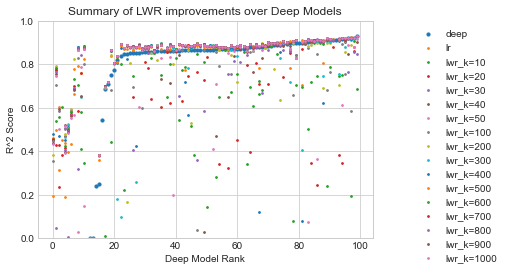

In [19]:
#take 1 is a scatter plot - lets, for each dataset
#graph our deep models by rank - plot - then overlay our knn moels
#plot points

deep_set = scores_df[scores_df["predictor"]=="deep"].sort_values("R2")
deep_set["order"] = [i for i in range(0,100)]
deep_ordering = {row["model_num"]:row["order"] for index, row in deep_set.iterrows()}

def order_models(x):
    x = [deep_ordering[i] for i in x]
    return x

fig, ax = plt.subplots()
set_deep = False
knn_models = scores_df["predictor"].unique()
for knn_model in knn_models:
    subset = scores_df[scores_df["predictor"]==knn_model]
    s=3
    if knn_model == "deep":
        s=10
    ax.scatter(x=order_models(subset["model_num"].tolist()), y=subset["R2"], s=s, label=knn_model)

#ax.set_ylim(0,scores_db["deep_mean"].max())
ax.set_ylim(0,1)
# plot residuals
ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
ax.set_ylabel("R^2 Score")
ax.set_xlabel("Deep Model Rank")
#ax.set_ylim(0,200)
#ax.set_yscale("symlog")
ax.set_title("Summary of LWR improvements over Deep Models")
plt.savefig(log_dir/f"summary_plot.png", bbox_inches='tight')
logging.getLogger().info("Wrote Summary Graph")

In [20]:
scores_df["n_features"] = [deep_models[i].n_features for i in scores_df["model_num"]] 
from matplotlib.colors import Colormap
import seaborn as sns #heatmap of features - pls model - score
class nlcmap(Colormap):
    def __init__(self, cmap, levels):
        self.cmap = cmap
        self.N = cmap.N
        self.monochrome = self.cmap.monochrome
        self.levels = np.asarray(levels, dtype='float64')
        self._x = self.levels
        self.levmax = self.levels.max()
        self.levmin = self.levels.min()
        self.transformed_levels = np.linspace(self.levmin, self.levmax, #uniform spacing along levels (colour segments)
             len(self.levels))

    def __call__(self, xi, alpha=1.0, **kw):
        yi = np.interp(xi, self._x, self.transformed_levels)
        return self.cmap((yi-self.levmin) / (self.levmax-self.levmin), alpha)
    
levels = np.concatenate((
    [0, 1],
    [0.6,0.8,0.9,0.95,0.98]
    ))

levels = levels[levels <= 1]
levels.sort()
cmap_nonlin = nlcmap(plt.cm.YlGnBu, levels)


In [21]:
subset = scores_df[["predictor","n_features","R2"]]
subset = subset[np.logical_not(subset["predictor"]=="deep")]
subset = subset[np.logical_not(subset["predictor"]=="lr")]
trans = subset["predictor"].transform(lambda x: int(x.replace("lwr_k=",""))).tolist()
subset.loc[:,"predictor"]=trans
subset=subset.sort_values("predictor",ascending=False)

def rand_jitter(arr):
    stdev = .01 * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev

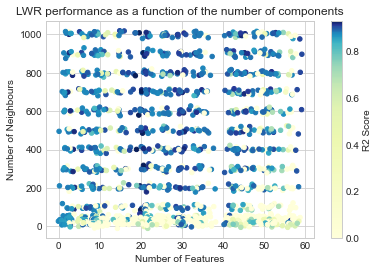

In [22]:
fig, ax = plt.subplots()
sc = ax.scatter(x=rand_jitter(subset["n_features"]), y=rand_jitter(subset["predictor"]), s=20,c=subset["R2"],cmap=cmap_nonlin,vmin=0)
ax.set_xlabel("Number of Features")
ax.set_ylabel("Number of Neighbours")

cbar = fig.colorbar(sc,label="R2 Score")

ax.set_title("LWR performance as a function of the number of components")
plt.savefig(log_dir/f"heat_scatter.png", bbox_inches='tight')